# __Trabalho Prático 1 - Algoritmos II__
```
Gabriela Tavares Barreto
Milena Corrêa Moreira
Rafaela de Fátima Silva Alexandre
```

## __Introdução__

Este trabalho prático tem como objetivo explorar e implementar algoritmos fundamentais de geometria computacional, com foco na resolução do problema de classificação em aprendizado de máquina supervisionado. Abordaremos aspectos práticos da implementação de algoritmos de envoltória convexa e verificação de interseção de segmentos, utilizando esses conceitos para criar um modelo de classificação linear.

A implementação do modelo de classificação linear se dará por meio da análise da separabilidade linear dos dados, assumindo um cenário bidimensional para simplificar a visualização. Nosso método verificará a sobreposição das classes através da computação de envoltórias convexas e, caso os dados sejam linearmente separáveis, criará um modelo linear representativo.

Em especial, vamos implementar algoritmos para resolver as seguintes tarefas: (1) envoltória convexa em conjunto de pontos,
(2) interseção de segmentos em conjunto de segmentos,
(3) pontos mais próximos em conjunto de pontos.

Para resolver o problema (1), escolhemos por implementar o algoritmo Gift Wrapping, também conhecido como algoritmo de Jarvis. Este algoritmo possui complexidade $O(nh)$, sendo $n$ o número de pontos e $h$ os pontos que efetivamente estão na envoltória. Apesar de apresentar semelhanças com o Algoritmo da Varredura de Graham, o Gift Wrapping se destaca por sua notável eficiência no melhor caso, com complexidade $O(n)$.

Para atender os propósitos deste trabalho, a princípio geramos duas envoltórias, uma para cada classe do conjunto de dados bidimensionais trabalhados.

Já para o problema (2), implementamos uma solução bem simples que verifica em no máximo tempo $O(hk)$ se dois conjuntos de segmentos possuem uma intersecção, onde $h$ é o número de pontos do primeiro conjunto, e $(k)$ o número de pontos do segundo conjunto. A ideia do algoritmo é bem simples: para cada segmento do primeiro conjunto, verificamos se há intersecção entre este segmentos e os demais segmentos do segundo conjunto. Caso uma intersecção seja encontrada, o algoritmo para e reporta que os conjuntos não são linearmente separáveis. No contexto deste trabalho, os conjuntos de segmentos são as próprias envoltórias convexas.

Para resolver o problema (3), foi implementado um algoritmo de varredura. Este algoritmo tem em seu melhor caso complexidade $O(nlog(n))$. Em seu pior caso, essa complexidade aumenta para $O(n^2)$. Dada a restrição de que cada ponto do par de pontos retornados precisa ser de um conjunto de pontos diferentes, o parâmetro de distância mínima, usado no algoritmo, tende a ter valores maiores do que se executássemos o algoritmo sem essa restrição. Portanto, espera-se que a complexidade executada esteja entre o caso médio e o pior caso do algoritmo.

Ao concluir estas três tarefas, foi possível então calcular a equação da reta classificadora, que é o modelo a ser reportado. O classificador funcionará da seguinte forma: o modelo classifica uma nova amostra de pontos atribuindo-a ao mesmo rótulo dos pontos da envoltória quando esta amostra se encontra abaixo ou à esquerda da reta gerada pelo modelo nessa região.

Além do mais, foi realizada uma avaliação do desempenho do modelo em vários conjuntos de dados reais, adaptados para o propósito do trabalho. A avaliação inclui métricas como precisão, revocação e F1-escore para mensurar a eficácia do modelo na tarefa de classificação.

A revocação mede a capacidade de um modelo em encontrar todos os exemplos positivos em um conjunto de dados. É calculado dividindo o número de exemplos positivos corretamente encontrados pelo modelo (verdadeiros positivos) pelo total de exemplos positivos, incluindo aqueles que o modelo não conseguiu encontrar (falsos negativos).

O F1-escore combina revocação e precisão em um único número, buscando um equilíbrio entre a capacidade do modelo de encontrar exemplos positivos e a precisão de suas previsões. É calculado usando uma média harmônica das duas métricas. Ele é útil quando você precisa considerar tanto falsos positivos.

Essas métricas são particularmente úteis em problemas de classificação onde o equilíbrio entre as classes é importante.

Sobre os experimentos, vamos documentar as etapas de pré-processamento dos dados, escolhas feitas durante o processo de treino e teste e os resultados obtidos no cálculo das métricas. Gráficos ilustrativos serão incluídos para proporcionar uma visualização clara do funcionamento do modelo.

Os experimentos serão conduzidos em pelo menos dez bases de dados distintas, extraídas de repositórios públicos, e o desempenho do modelo será avaliado em diferentes cenários. O uso de técnicas de redução de dimensionalidade, como t-SNE, PCA ou SVD, será explorado para adequar os dados ao formato bidimensional necessário para nosso modelo.

## __1. Bibliotecas__
Algumas bibliotecas que vamos usar para facilitar os experimentos com os conjuntos de dados.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

## __2. Envoltória convexa__
Implementação do algoritmo Gift Wrapping (Jarvis March) para determinar as envoltórias das amostras. Este algoritmo possui complexidade $O(nh)$, sendo $n$ o número de pontos e $h$ os pontos que efetivamente estão na envoltória.

In [2]:
# classe para representar pontos bidimensionais no espaço
class Ponto:
    def __init__(self, x, y, rotulo):
        self.x = x
        self.y = y
        self.rotulo = rotulo

In [3]:
# calculando o produto vetorial entre segmentos ab e ac, a = ancora
def produto_vetorial(ancora, b, c):
    return ((b.x-ancora.x)*(c.y-ancora.y) - (c.x-ancora.x)*(b.y-ancora.y))


In [4]:
# encontrando o ponto mais embaixo em relação a y
def mais_a_esquerda(pontos):
    min = 0
    for i in range(1,len(pontos)):
        if pontos[i].y < pontos[min].y:
            min = i
        elif pontos[i].y == pontos[min].y:
            if pontos[i].x < pontos[min].x: # em caso de empate, escolhemos o ponto mais a esquerda
                min = i
    return min

In [5]:
# funcao que recebe um vetor de pontos, e retorna lista com pontos da envoltoria convexa
def gift_wrapping(pontos):
    i_esquerda = mais_a_esquerda(pontos) # guarda indice do ponto mais a esquerda
    p = pontos[i_esquerda]

    prox = (i_esquerda + 1) % len(pontos)

    teste = 0

    envoltoria = [] #incializa envoltoria vazia
    envoltoria.append(p) # adiciona ponto mais à esquerda a envoltoria

    q = p
    while(True):
        # calcula o prox ponto da envoltoria
        while(teste != len(pontos)):
            det = produto_vetorial(q, pontos[prox], pontos[teste])
            if det < 0: # se for negativo, pontos[teste] tem o menor angulo polar,sendo o prox ponto da envoltoria
                prox = teste
            # atualiza teste
            teste = teste+1;

        # se tivermos retornados a ancora, loop acaba
        if p == pontos[prox]:
            break

        # adiciona ponto a envoltoria
        envoltoria.append(pontos[prox])

        # atualiza variáveis
        q = pontos[prox]
        prox = (prox + 1) % len(pontos)
        teste = 0

    return envoltoria

## __3. Separabilidade Linear__

Este algoritmo verifica se dois conjuntos de segmentos têm uma interseção em um tempo máximo de $O(hk)$, onde $h$ é o número de pontos no primeiro conjunto e $k$ é o número de pontos no segundo conjunto. O funcionamento é simples: para cada segmento do primeiro conjunto, ele verifica se há interseção com os segmentos do segundo conjunto. Se uma interseção for encontrada, o algoritmo para e indica que os conjuntos não são linearmente separáveis. No contexto deste trabalho, os conjuntos de segmentos são, na verdade, as próprias envoltórias convexas.

A função auxiliar que determina se dois segmentos se interceptam foi implementada de maneira similar à implementação vista em sala de aula, e funciona da seguinte forma: para determinar se dois segmentos se interceptam, o algoritmo verifica se eles cruzam as retas que se sobrepõem. Dois segmentos se interceptam se pelo menos uma das seguintes condições for verdadeira:
(1) Cada segmento cruza a reta que se sobrepõe ao outro segmento.
(2) Um dos extremos de um segmento está localizado sobre o outro segmento.


In [6]:
def on_segment(p1, p2, p):
    return min(p1.x, p2.x) <= p.x <= max(p1.x, p2.x) and min(p1.y, p2.y) <= p.y <= max(p1.y, p2.y)

In [7]:
def intersect(p1, p2, p3, p4):
    d1 = produto_vetorial(p3, p4, p1)
    d2 = produto_vetorial(p3, p4, p2)
    d3 = produto_vetorial(p1, p2, p3)
    d4 = produto_vetorial(p1, p2, p4)

    if ((d1 > 0 and d2 < 0) or (d1 < 0 and d2 > 0)) and \
        ((d3 > 0 and d4 < 0) or (d3 < 0 and d4 > 0)):
        return True

    elif d1 == 0 and on_segment(p3, p4, p1):
        return True
    elif d2 == 0 and on_segment(p3, p4, p2):
        return True
    elif d3 == 0 and on_segment(p1, p2, p3):
        return True
    elif d4 == 0 and on_segment(p1, p2, p4):
        return True
    else:
        return False

In [8]:
def any_segment_intersect(envoltoria_1, envoltoria_2):
    n = len(envoltoria_1)
    m = len(envoltoria_2)
    for i in range(n):
        for j in range(m):
            if intersect(envoltoria_1[i], envoltoria_1[(i + 1) % n], envoltoria_2[j], envoltoria_2[(j + 1) % m]):
                print("Os dados NÃO são linearmente separáveis.")
                return True
    print("Os dados são linearmente separáveis.")
    return False

## __4. Pontos mais próximos entre duas envoltórias__
Este algoritmo de varredura tem em seu melhor caso complexiadade $O(nlog(n))$. Em seu pior caso, essa complexidade aumenta para $O(n^2)$. Dada a restrição de que cada ponto do par de pontos retornados precisa ser de um conjunto de pontos diferentes, o parâmetro de distância mínima, usado no algoritmo, tende a ter valores maiores do que se executássemos o algoritmo sem essa restrição. Portanto, espera-se que a complexidade executada esteja entre o caso médio e o pior caso do algoritmo.

In [9]:
import sys
import math

# função que retorna par de pontos rotulados mais próximo entre dois conjuntos de pontos rotulados
def par_mais_proximo(pontos):
    # inicializando variáveis
    p1 = (0,0,0)
    p2 = p1

    # ordena a lista de objetos com base nas coordenadas x dos pontos
    ordenados_X = sorted(pontos, key=lambda obj: obj.x)

    # menor distancia inicializada com valor alto
    min = sys.maxsize

    # criando objeto do tipo conjunto
    st = set()
    # adiciona ponto mais a esquerda ao conjunto
    st.add(ordenados_X[0])

    # varredura sobre pontos ordenados em X
    for i in range(1, len(ordenados_X)):
        # cria conjunto de pontos a esquerda do ponto atual numa distancia no máximo d
        l = set([p for p in st if (p.x >= ordenados_X[i].x - min) and (p.y >= ordenados_X[i].y - min) ])
        # conjunto de pontos a direita do ponto atual a uma distancia no máximo d
        r = set([p for p in st if (p.x <= ordenados_X[i].x + min) and (p.y <= ordenados_X[i].y + min)])
        # intercessao de pontos que podem ter distancia menor que d entre si
        intersection = l & r

        # se não houver pontos com distancias possivelmente menores, passa para o proximo ponto ordenado
        if len(intersection) == 0:
            continue

        # loop sobre a interseção dos conjuntos l e r
        for val in intersection:
            if ordenados_X[i].rotulo == val.rotulo:
                continue

            # Calcula a distância entre os pontos
            dist = math.sqrt(math.pow(ordenados_X[i].x - val.x, 2) + math.pow(ordenados_X[i].y - val.y, 2))

            # Atualiza a distância mínima, se necessário
            if min > dist:
                min = dist
                # guardando o par de pontos mais prox até o momento
                p1 = ordenados_X[i]
                p2 = val

        st.add(ordenados_X[i])

    return p1, p2

## __5. Equação da reta classificadora__
Para qualquer equação linear $y = mx + b$, as perpendiculares à ela terão todas uma inclinação de $-1/m$, o recíproco oposto da inclinação original. Para encontrar uma reta perpendicular de um dado segmento $p1p2$, sendo que esta reta também passa por um ponto específico $(x, y)$, nesse caso, a mediana do segmento, basta resolver a equação $y = (-1/m)x + b$, substituindo os valores conhecidos de $m$, $x$ e $y$ para resolver $b$.


In [10]:
# retorna  m e b da equação da reta perpendicular
def reta_perpendicular(p1, p2):
    inclinacao_original = (p1.y-p2.y)/(p1.x-p2.x)

    inclinacao_perpendicular = (-1.0)/inclinacao_original
    # calcula a mediana
    mediana = ((p1.x + p2.x)/2, (p1.y + p2.y)/2) # ponto da mediana

    b = mediana[1] - inclinacao_perpendicular * mediana[0]
    return (b, inclinacao_perpendicular)

# função para calcular os valores y da reta dada um inclinação m e intercessao b
def reta(m, b, x):
    return m * x + b

## __6. Classificador__
É uma tarefa muito simples classificar os pontos de teste a partir do momento que temos a equação da reta classificadora. Basta pegar a coordenada $x$ do ponto (feature) e calcular a coordenada $y$. A posição do $y$ em relação a reta determina de qual classe ele é.

É uma tarefa mutio simples classificar os pontos de teste a partir do momento que temos a equação da reta classificadora. Basta pegar a coordenada $x$ do ponto (feature) e calcular a coordenada $y$. A posição do $y$ em relação a reta determina de qual classe ele é.

In [11]:
def classificar_pontos(P1, P2, pontos, R1, R2):
    b, m = reta_perpendicular(P1, P2)
    labels = []

    for ponto in pontos:
        x, y = ponto.x, ponto.y
        y_na_reta = reta(m, b, x)

        # classifica o ponto com base na posição em relação a reta
        if y >= y_na_reta:
            labels.append(R1)
        elif y < y_na_reta:
            labels.append(R2)
        else:
            labels.append(-1) # caso default

    return labels

## __7. Funções para pré-processamento dos dados__

A ideia destas funções é facilitar a realização dos experimentos com os conjuntos de dados. Apesar de não funcionarem para todos os datasets, já que todos são diferentes e, portanto, necessitam de diferentes manipulações, elas nortearam o passo a passo dos experimentos nas fases iniciais do trabalho.

### 2.1 Carregar dados
Vamos carregar os dados com os quais vamos trabalhar. Para melhor visualização, num primeiro momento escolhemos representar os dados em uma estrutura DataFrame, disponível na biblioteca Pandas.

In [12]:
def carregar_dados(dataset):
    df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
    df['Target'] = pd.DataFrame(dataset.target)
    return df

### 2.2 SVD
Uma vez que vamos trabalhar apenas com pontos no plano cartesiano, precisamos transformar nossos dados em uma **matriz bidimensional**. Para isso, utilizaremos a técnica **SVD** (Singular Value Decomposition) que reduz uma matriz *n*-dimensional em uma matriz *k*-dimensional, onde *k* é o número de fatores latentes. Para nosso trabalho, *k* é sempre 2.

In [13]:
def svd(df, dataset):
    svd = TruncatedSVD(n_components=2, n_iter=4, random_state=42)
    df.drop(columns=['Target'])
    dados_transformados = svd.fit_transform(df)
    df_bidimensional = pd.DataFrame(dados_transformados, columns=['x','y'])
    df_bidimensional['Target'] = pd.DataFrame(dataset.target)
    return df_bidimensional

### 2.3 Gerar dados bidimensionais


In [14]:
def processar_dados(dataset):
  df_original = carregar_dados(dataset)
  df_svd = svd(df_original, dataset)
  return df_svd

### 2.4 Separar os dados em treino e teste
Aqui vamos gerar conjuntos de treino e de teste na proporção 70:30. Os pontos de cada conjunto são selecionados aleatoriamente.

In [15]:
def separar_dados(df):
    features = df[['x', 'y']].values
    targets = df['Target'].values

    features_train, features_test, targets_train, targets_test = train_test_split(features, targets, test_size=0.3, random_state=50)

    df_treino = pd.DataFrame(features_train, columns=['x','y'])
    df_treino['Target'] = pd.DataFrame(targets_train)

    df_teste = pd.DataFrame(features_test, columns=['x','y'])
    df_teste['Target'] = pd.DataFrame(targets_test)

    return df_treino, df_teste, targets_train, targets_test

### 2.5 Editar rótulos

Para fins de simplificação, vamos trabalhar apenas com dois rótulos em cada conjunto de dados.

In [16]:
def editar_rotulos(df, rotulo_A, rotulo_B):
    return df.loc[df['Target'].isin([rotulo_A, rotulo_B])]

## __8. Outras funções__
Algumas funções que buscam auxiliar a realização dos experimentos.

In [17]:
def gerar_grafico_envoltorias(df, dataset):
    envoltorias = []
    plt.clf()
    plt.figure(figsize = (10, 6))
    names = dataset.target_names
    label = (dataset.target).astype(int)
    for i in range(len(names)):
        classe = df[df['Target'] == i]
        classe = classe.values
        classe_points = [Ponto(x, y, r) for x, y, r in classe]
        envoltorias.append(gift_wrapping(classe_points))
        Xs1 = [ponto.x for ponto in classe_points]
        Ys1 = [ponto.y for ponto in classe_points]
        plt.scatter(Xs1, Ys1, s=20, label=names[i])
        Xs2 = [ponto.x for ponto in envoltorias[i]]
        Ys2 = [ponto.y for ponto in envoltorias[i]]
        Xs2.append(envoltorias[i][0].x)
        Ys2.append(envoltorias[i][0].y)
        for j in envoltorias:
            plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')
    plt.legend()
    plt.show()

In [18]:
def gerar_pontos(df, rotulo_A, rotulo_B):
    classe_A = df[df['Target'] == rotulo_A]
    classe_A = classe_A.values
    pontos_A = [Ponto(x, y, r) for x, y, r in classe_A]

    classe_B = df[df['Target'] == rotulo_B]
    classe_B = classe_B.values
    pontos_B = [Ponto(x, y, r) for x, y, r in classe_B]

    return pontos_A, pontos_B


In [19]:
def gerar_envoltorias(A, B):
    envoltoria_A = gift_wrapping(A)
    envoltoria_B = gift_wrapping(B)
    return envoltoria_A, envoltoria_B

In [20]:
def gerar_reta(pontos_A, pontos_B, envoltoria_A, envoltoria_B):
    uniao = pontos_A + pontos_B
    p1, p2 = par_mais_proximo(uniao)
    P1 = Ponto(p1.x, p1.y, p1.rotulo)
    P2 = Ponto(p2.x, p2.y, p2.rotulo)
    b, m = reta_perpendicular(P1,P2)
    gerar_grafico_reta(b, m, 3, 10, pontos_A, pontos_B, envoltoria_A, envoltoria_B, P1, P2)
    return b, m

In [21]:
def gerar_grafico_reta(b, m, inicio_reta, fim_reta, pontos_A, pontos_B, envoltoria_A, envoltoria_B, P1, P2):
    x_valores = np.linspace(inicio_reta, fim_reta, 50)
    y_valores = reta(m, b ,x_valores)

    plt.clf()
    plt.figure(figsize = (10, 6))

    Xs1 = [ponto.x for ponto in pontos_A]
    Ys1 = [ponto.y for ponto in pontos_A]
    plt.scatter(Xs1, Ys1, s=20)
    Xs2 = [ponto.x for ponto in envoltoria_A]
    Ys2 = [ponto.y for ponto in envoltoria_A]
    Xs2.append(envoltoria_A[0].x)
    Ys2.append(envoltoria_A[0].y)
    for p in envoltoria_A:
        plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')

    Xs1 = [ponto.x for ponto in pontos_B]
    Ys1 = [ponto.y for ponto in pontos_B]
    plt.scatter(Xs1, Ys1, s=20)
    Xs2 = [ponto.x for ponto in envoltoria_B]
    Ys2 = [ponto.y for ponto in envoltoria_B]
    Xs2.append(envoltoria_B[0].x)
    Ys2.append(envoltoria_B[0].y)
    for p in envoltoria_B:
        plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')


    # plotando a reta classificadora
    plt.plot(x_valores, y_valores, color='orange')

    # Adiciona uma linha entre o par de pontos mais próximo
    plt.plot([P1.x,P2.x], [P1.y,P2.y], 'k--')
    plt.title('Modelo de classificação')
    plt.show()

#__Experimentos__
Os experimentos neste trabalho contemplam 11 bases de dados extraídas de repositórios de dados públicos.

Em um primeiro momento, buscamos trabalhar com os toy datasets já presentes na biblioteca sklearn, uma vez que eles apresentam características desejáveis como atributos numéricos, poucas classificações e poucas classes. Assim, a parte de pré-processamento dos dados foi mais automatizada.

No entanto, também escolhemos alguns datasets com milhares de observações e que necessitam de um pré-processamento mais detalhado.

Após o processamento inicial dos dados, buscamos aplicar métodos para diminuir a dimensão dos dados. Para cada dataset, escolhemos um dos três métodos: SVD, PCA ou t-SNE.

Após esta etapa, separamos os dados em conjunto de treino e conjunto de teste. Em alguns datasets separamos os dados aleatoriamente, de forma que o conjunto de treino ficasse com 70% das observações e o conjunto de teste com 30%. No entanto, na grande maioria dos datasets foi necessário manipular intervalos ou remover outliers de modo a obter um conjunto de treino linearmente separável. Nesses casos, ainda assim tentamos manter a proporção 70:30 para treino e teste.

Feito isto, geramos as envoltórias para cada classe no conjunto de treino, por meio do algoritmo Gift Wrapping. Depois, verificamos a separabilidade linear das envoltórias com um algoritmo que verifica a existência de pelo menos uma intersecção entre segmentos de reta num conjunto de pontos.

Se as envoltórias realmente são linearmente separáveis, então partimos para o algoritmo de varredura que identifica os dois pontos mais próximos entre as duas envoltórias. Em sequência, geramos a reta perpendicular a reta que une os dois pontos mais próximos. Essa reta será a reta utilizada para classificar os pontos do conjunto de teste.

Nesta parte, desenvolvemos uma função simples que verifica se um dado ponto está abaixo/à esquerda da reta em relação os pontos da envoltória de uma região. É essa função que de fato prediz a qual classe uma observação pertence.

Para todos os experimentos, geramos gráficos que mostram a distribuição dos pontos no plano cartesiano, as envoltórias convexas geradas, os pontos mais próximas, e por fim a reta classificadora.

Em alguns casos também achamos relevante plotar gráficos da distribuição dos conjuntos de treino e teste, bem como das envoltórias convexas de todas as classes existentes no dataset, para fins de observação.

## __1. Iris dataset__

O Iris é um dos toy datasets disponíveis na biblioteca sklearn, e foi usado como base para os primeiros experimentos dos algoritmos implementados neste trabalho por ser um dataset que possui apenas 150 observações distribuídas igualmente entre 3 classes. Além disso, uma das classes é linearmente separável, enquanto as outras duas não são. Essas características auxiliaram principalmente no processo de desenvolvimento e teste dos algoritmos que geram a envoltória convexa e a separabilidade linear das envoltórias.

Para trabalhar com o Iris, escolhemos por manter apenas as duas classes linearmente separáveis. Este foi o dataset mais fácil de manipular, pois os pontos de cada classe estavam em regiões bem distintas no plano. Desta forma, ao classificar os pontos do conjunto de teste, todas as métricas obtiveram o valor máximo:

**a) Precisão: 1.0**

**b) Revocação: 1.0**

**c) F1-escore: 1.0**




In [22]:
# Carregar dados
iris = datasets.load_iris()
df = processar_dados(iris)

<Figure size 640x480 with 0 Axes>

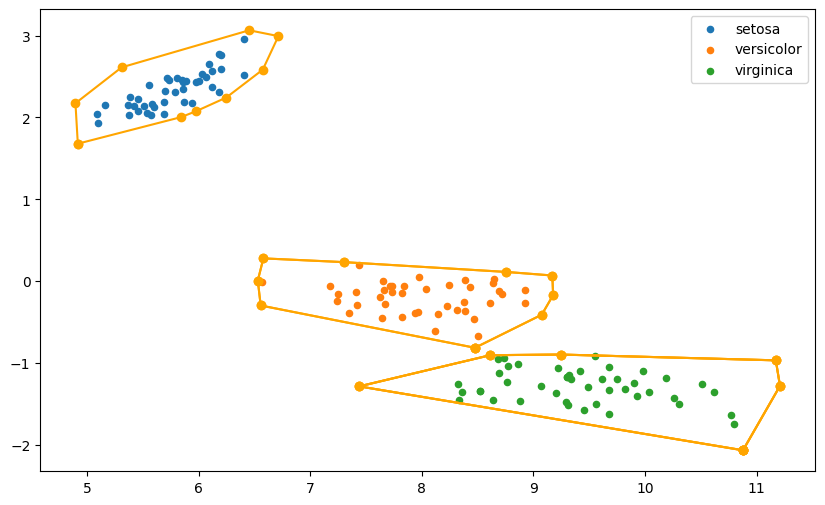

In [23]:
# Gerar todas as envoltórias
gerar_grafico_envoltorias(df, iris)

In [24]:
# Manter apenas os rotulos linearmente separáveis
df = editar_rotulos(df, 0, 1)

In [25]:
# Separar os dados em conjunto de treino e conjunto de teste
df_treino, df_teste, targets_treino, targets_teste = separar_dados(df)

In [26]:
# Gerar os pontos
pontos_A, pontos_B = gerar_pontos(df_treino, 0, 1)

In [27]:
# Gerar as envoltórias convexas
envoltoria_A, envoltoria_B = gerar_envoltorias(pontos_A, pontos_B)

In [28]:
# Verificar se as envoltórias são linearmente separáveis
any_segment_intersect(envoltoria_A, envoltoria_B)

Os dados são linearmente separáveis.


False

<Figure size 640x480 with 0 Axes>

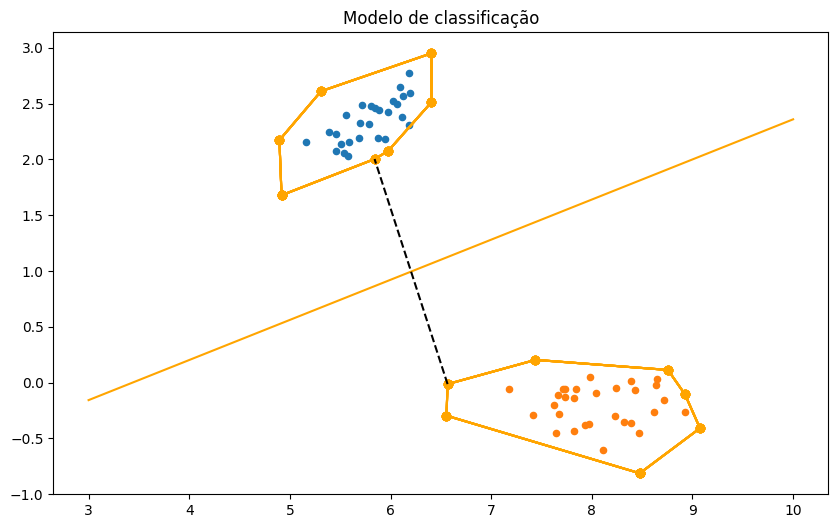

In [29]:
# Gerar a reta classificadora
b, m = gerar_reta(pontos_A, pontos_B, envoltoria_A, envoltoria_B)

In [30]:
# Gerar pontos do conjunto de teste
pontos_teste = [Ponto(x, y, r) for x, y, r in df_teste.values]
uniao = pontos_A + pontos_B

# Identificar o par de pontos mais próximas no dataset
p1, p2 = par_mais_proximo(uniao)

# Classificar pontos
rotulos_teste = classificar_pontos(p1, p2, pontos_teste, 0, 1)

In [31]:
# Calcular as métricas
recall = recall_score(targets_teste, rotulos_teste)
precision = precision_score(targets_teste, rotulos_teste)
f1 = f1_score(targets_teste, rotulos_teste)

print(f'Precisão: {precision}')
print(f'Revocação: {recall}')
print(f'F1-escore: {f1}')

Precisão: 1.0
Revocação: 1.0
F1-escore: 1.0


## __2. Digits Dataset__


O Digits dataset é outro toy dataset da biblioteca sklearn. Porém, diferentemente do Iris, nenhuma das suas classes são linearmente separáveis.
Dessa forma, foi necessário observar de antemão quais seriam as duas classes mais distantes no plano, pois o nosso intuito é gerar envoltórias convexas linearmente separáveis.

Assim, dentre as 10 classes do dataset, escolhemos as classes 3 e 4. Esta escolha foi baseada no gráfico das envoltórias convexas.

No entanto, as envoltórias destas classes ainda possuem alguns pontos de intersecção, embora poucos. A abordagem escolhida para lidar com estes pontos foi simplesmente removê-los do dataset, de forma que as duas classes passaram a gerar envoltórias convexas linearmente separáveis.

Depois, realizamos o passo a passo para gerar a reta classificadora, e classificamos os pontos do conjunto de treino. Neste conjunto, as métricas obtiveram valores muito próximos do 1.

**a) Precisão: 1.0**

**b) Revocação: 0.98**

**c) F1-escore: 0.99**



In [32]:
# Carregar dataset
digits = datasets.load_digits()
# Criar dataframe
df_digits = processar_dados(digits)



<Figure size 640x480 with 0 Axes>

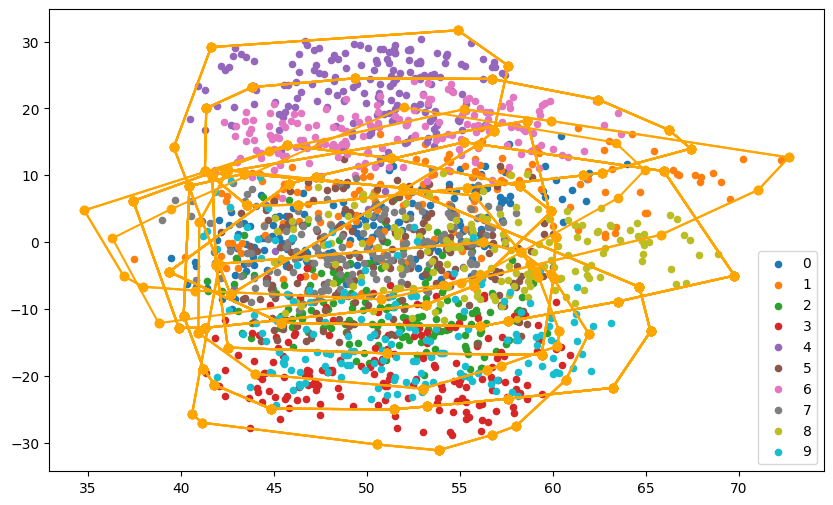

In [33]:
# gerar um grafico de todas as envoltorias convexas possiveis
gerar_grafico_envoltorias(df_digits, digits)

Perceba que as classes rotuladas como 3 e 4 estão mais distantes. Vamos selecioná-las.

In [34]:
# Selecionar as linhas onde o rótulo é 3 ou 4
df_digits = editar_rotulos(df_digits, 3, 4)

In [35]:
# Remover pontos para tornar as classes linearmente separáveis
df_digits =  df_digits[(df_digits['Target'] != 4) | (df_digits['y'] >= 0)]

# Mapear os rótulos para números inteiros
df_digits['Target'] = df_digits['Target'].replace({3: 1, 4: 0})

In [36]:
# Separar o dataset em treino e teste
df_treino, df_teste, targets_treino, targets_teste = separar_dados(df_digits)

In [37]:
# Gerar os pontos para o conjunto de treino
pontos_A, pontos_B = gerar_pontos(df_treino, 1, 0)

In [38]:
# Gerar as envoltórias para o conjunto de treino
envoltoria_A, envoltoria_B = gerar_envoltorias(pontos_A, pontos_B)

In [39]:
# Verificar se os segmentos se interceptam
any_segment_intersect(envoltoria_A, envoltoria_B)

Os dados são linearmente separáveis.


False

<Figure size 640x480 with 0 Axes>

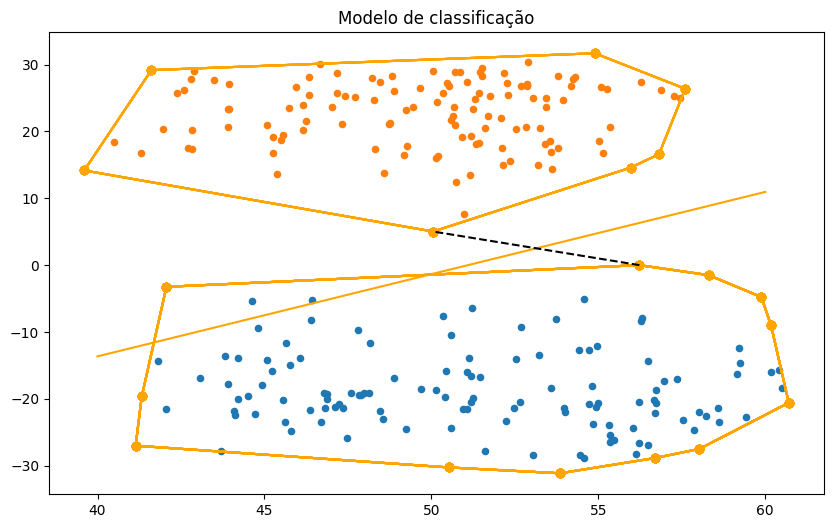

In [40]:
# Gerar reta classificadora
uniao = pontos_A + pontos_B
p1, p2 = par_mais_proximo(uniao)
P1 = Ponto(p1.x, p1.y, p1.rotulo)
P2 = Ponto(p2.x, p2.y, p2.rotulo)
b, m = reta_perpendicular(P1,P2)
gerar_grafico_reta(b, m, 40, 60, pontos_A, pontos_B, envoltoria_A, envoltoria_B, P1, P2)

In [41]:
# Gerar pontos para conjunto de teste
pontos_teste = [Ponto(x, y, r) for x, y, r in df_teste.values]

# Classificar conjunto de teste
pred_teste = classificar_pontos(p1, p2, pontos_teste, 0, 1)

In [42]:
# Calcular as métricas
recall = recall_score(targets_teste, pred_teste)
precision = precision_score(targets_teste, pred_teste)
f1 = f1_score(targets_teste, pred_teste)

print(f'Precisão: {precision}')
print(f'Revocação: {recall}')
print(f'F1-escore: {f1}')

Precisão: 1.0
Revocação: 0.9818181818181818
F1-escore: 0.9908256880733944


## __3. Wine Dataset__


O dataset wine é o conjunto Estes dados são o resultado de uma análise química de vinhos cultivados na mesma região da Itália, mas derivados de três cultivares diferentes. A análise determinou as quantidades de 13 constituintes encontrados em cada um dos três tipos de vinhos. O dataset possui 178 instancias, e o objetivo é determinar a origem de vinhos.

Para esse dataset, o meio de processamento para diminuir os dados utilizou o SVD.

Os resultados das métricas foram o seguinte:

**a) Precisão: 0.84**

**b) Revocação: 0.92**

**c) F1-escore: 0.88**


In [43]:
# Carregar dados
wine = datasets.load_wine()
df_wine = processar_dados(wine)

<Figure size 640x480 with 0 Axes>

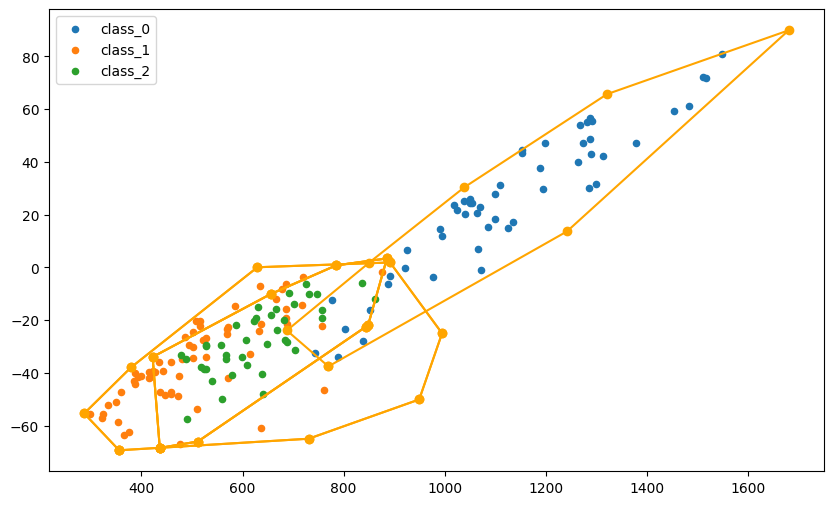

In [44]:
# Gerar grafico das envoltorias
gerar_grafico_envoltorias(df_wine, wine)

Ao plotar os pontos e suas envoltórias, podemos perceber que temos um dataset que não é linearmente separável, já que temos pontos das classes que se interceptam. Dito isso, foram feitas algumas mudanças em relação as classes, para operarmos apenas com as classes 0 e 1:|

In [45]:
# Modificar o dataset para operar com apenas duas classes
df_wine = editar_rotulos(df_wine, 0, 1)

Após isso, dividimos o dataset, usando a função *separar_dados*, que separa o dataset em 30% teste e 70% treino.


In [46]:
# Dividir dataset em conjuntos de treino e de teste
df_treino_wine, df_teste_wine, targets_treino_wine, targets_teste_wine = separar_dados(df_wine)

In [47]:
# Gerar pontos do conjunto de treino
pontos_A_wine, pontos_B_wine = gerar_pontos(df_treino_wine, 1, 0)

In [48]:
# Gerar envoltórias convexas do conjunto de treino
envoltoria_A_wine, envoltoria_B_wine = gerar_envoltorias(pontos_A_wine, pontos_B_wine)

In [49]:
# Verificar se os dados são linearmente separáveis
any_segment_intersect(envoltoria_A_wine, envoltoria_B_wine)

Os dados NÃO são linearmente separáveis.


True

Já que os dados não eram linearmente separáveis, a ideia para a separação do dataset em teste e treinamento foi baseada no seguinte critério:



1.   Pontos que estão misturados, são usados para teste
2.   Pontos que estão visivelmente separados, são usados como treinamento.





<ipython-input-50-104b2fa29e6c>:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_treino_wine.x, df_treino_wine.y, c='orange', label='Treino', cmap=plt.cm.Set1, edgecolor='k', alpha=0.7)
<ipython-input-50-104b2fa29e6c>:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_teste_wine.x, df_teste_wine.y, c='grey', label='Teste', cmap=plt.cm.Set1, edgecolor='k', alpha=0.7)


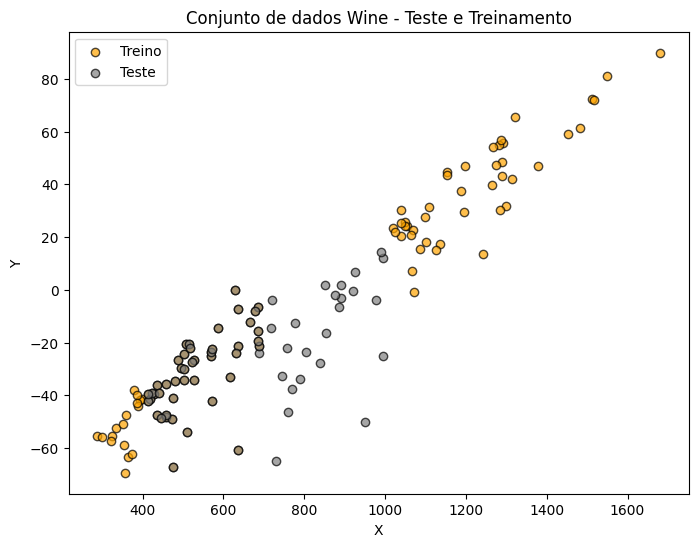

In [50]:
# Após visualizar como os dados estao dispostos, dividir corretamente em teste e treinamento
df_treino_wine = df_wine[(df_wine['x'] > 1000) & (df_wine['Target'] == 0) | (df_wine['x'] <= 700) & (df_wine["Target"] == 1)]
df_teste_wine = df_wine[(df_wine['x'] > 400) & (df_wine['x'] <= 1000)]

target_wine = df_treino_wine.Target
target_wine_test = df_teste_wine.Target

# Plotar os dados reduzidos
plt.figure(figsize=(8, 6))
plt.scatter(df_treino_wine.x, df_treino_wine.y, c='orange', label='Treino', cmap=plt.cm.Set1, edgecolor='k', alpha=0.7)
plt.scatter(df_teste_wine.x, df_teste_wine.y, c='grey', label='Teste', cmap=plt.cm.Set1, edgecolor='k', alpha=0.7)
plt.legend()
plt.title('Conjunto de dados Wine - Teste e Treinamento')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [51]:
# Gerar novamente os pontos para o conjunto de treino atualizado
pontos_A_wine1, pontos_B_wine1 = gerar_pontos(df_treino_wine,0,1)
envoltoria_A_wine1, envoltoria_B_wine1 = gerar_envoltorias(pontos_A_wine1, pontos_B_wine1)

Após isso, as envoltorias dos pontos de treinamento são analisados: agora eles não se interceptam

In [52]:
# Verfificar se as envoltórias são linearmente separáveis
any_segment_intersect(envoltoria_A_wine1, envoltoria_B_wine1)

Os dados são linearmente separáveis.


False

In [53]:
pontos_treino_wine = [Ponto(x, y, r) for x, y, r in df_treino_wine.values]
pontos_teste_wine = [Ponto(x, y, r) for x, y, r in df_teste_wine.values]

uniao = pontos_A_wine1 + pontos_B_wine1
p1, p2 = par_mais_proximo(uniao)
rotulos_teste_wine = classificar_pontos(p1, p2, pontos_teste_wine,0,1)


<Figure size 640x480 with 0 Axes>

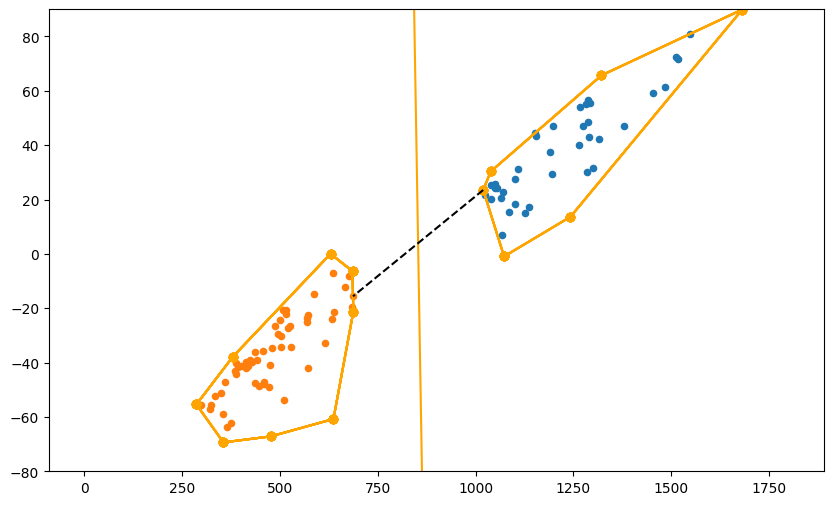

In [54]:
p1, p2 = par_mais_proximo(uniao)
P1 = Ponto(p1.x, p1.y, p1.rotulo)
P2 = Ponto(p2.x, p2.y, p2.rotulo)
b, m = reta_perpendicular(P1,P2)

x_valores = np.linspace(0, 1800, 50)
y_valores = reta(m, b ,x_valores)

plt.clf()
plt.figure(figsize = (10, 6))

Xs1 = [ponto.x for ponto in pontos_A_wine1]
Ys1 = [ponto.y for ponto in pontos_A_wine1]
plt.scatter(Xs1, Ys1, s=20)
Xs2 = [ponto.x for ponto in envoltoria_A_wine1]
Ys2 = [ponto.y for ponto in envoltoria_A_wine1]
Xs2.append(envoltoria_A_wine1[0].x)
Ys2.append(envoltoria_A_wine1[0].y)


for p in envoltoria_A_wine1:
    plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')

Xs1 = [ponto.x for ponto in pontos_B_wine1]
Ys1 = [ponto.y for ponto in pontos_B_wine1]
plt.scatter(Xs1, Ys1, s=20)
Xs2 = [ponto.x for ponto in envoltoria_B_wine1]
Ys2 = [ponto.y for ponto in envoltoria_B_wine1]
Xs2.append(envoltoria_B_wine1[0].x)
Ys2.append(envoltoria_B_wine1[0].y)
for p in envoltoria_B_wine1:
    plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')

# plotando a reta classificadora
plt.plot(x_valores, y_valores, color='orange')

# Adiciona uma linha entre o par de pontos mais próximo
plt.plot([p1.x,p2.x], [p1.y,p2.y], 'k--')
plt.ylim(-80, 90)

plt.show()

Analisando as métricas
1.   A precisão é aproximadamente 0.847, o que significa que 84.7% das previsões positivas feitas pelo modelo são realmente corretas.
2.    A revocação mede a capacidade do modelo de identificar todos os casos positivos. Nesse caso, a revocação é aproximadamente 0.926, o que significa que o modelo consegue identificar 92.6% de todos os casos positivos.
3. O F1-score é uma métrica que combina precisão e revocação em uma única pontuação, nesse caso, obtemos um bom equilibrio entre as duas métricas, ao análisar o F1-score



In [55]:
recall = recall_score(target_wine_test, rotulos_teste_wine)
precision = precision_score(target_wine_test, rotulos_teste_wine)
f1 = f1_score(target_wine_test, rotulos_teste_wine)

print(f'Precisão: {precision}')
print(f'Revocação: {recall}')
print(f'F1-escore: {f1}')

Precisão: 0.847457627118644
Revocação: 0.9259259259259259
F1-escore: 0.8849557522123893


## __4. Breast Cancer Dataset__

O conjunto de dados "Breast Cancer" do scikit-learn consiste em 569 instâncias de biópsias de câncer de mama, com 30 atributos numéricos derivados de imagens. O objetivo é prever se um tumor é maligno ou benigno (classificação binária). Este conjunto é amplamente utilizado em tarefas de aprendizado de máquina para diagnóstico de câncer de mama, com aplicações clínicas significativas.

Os resultados das métricas para este conjunto de dados foram o seguinte:

**a) Precisão: 0.94**

**b) Revocação: 0.85**

**c) F1-escore: 0.89**

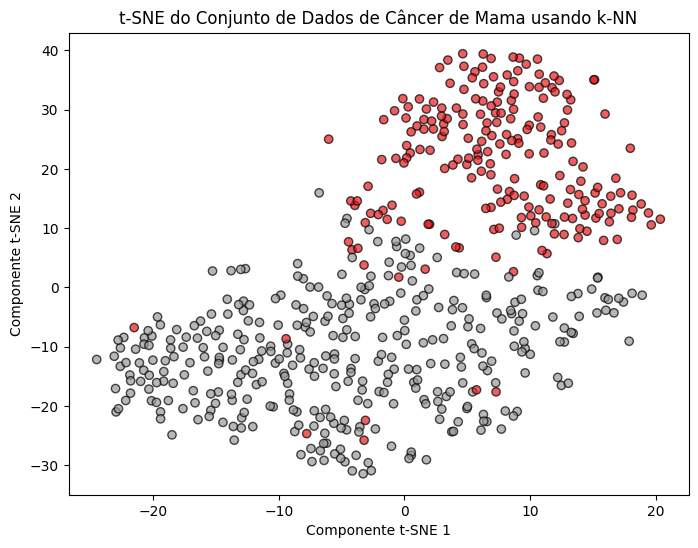

In [56]:
from sklearn.datasets import load_breast_cancer

# Carregar o conjunto de dados de câncer de mama
dados = load_breast_cancer()

# Padronizar os dados
X_padronizado = StandardScaler().fit_transform(dados.data)

# Usar k-NN para encontrar os vizinhos
n_vizinhos = 5
vizinhos = NearestNeighbors(n_neighbors=n_vizinhos)
ajuste_vizinhos = vizinhos.fit(X_padronizado)
distancias, indices = ajuste_vizinhos.kneighbors(X_padronizado)

# Usar t-SNE para redução de dimensionalidade
tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate=200)
X_tsne = tsne.fit_transform(X_padronizado)

# Adicionar rótulo à matriz de pontos
X_tsne_com_rotulo = np.column_stack((X_tsne, dados.target))

# Plotar os dados reduzidos
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=X_tsne_com_rotulo[:, 2], cmap=plt.cm.Set1, edgecolor='k', alpha=0.7)
plt.title('t-SNE do Conjunto de Dados de Câncer de Mama usando k-NN')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.show()


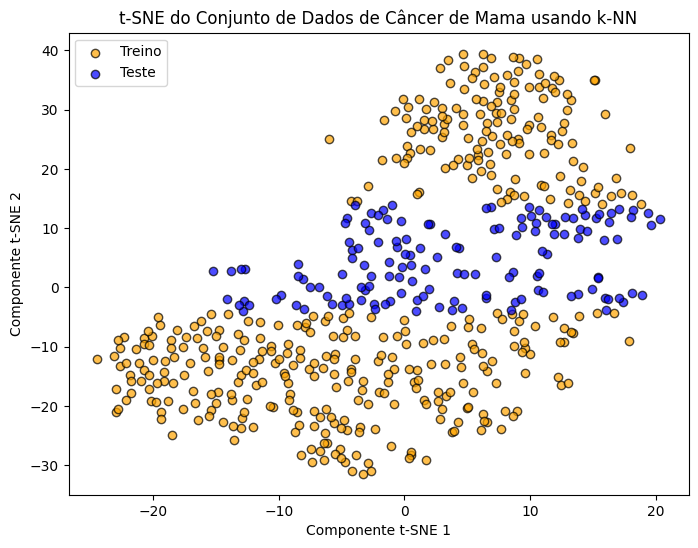

In [57]:

# Adiciona coluna rótulo à matriz de pontos
X_tsne_com_rotulo = np.column_stack((X_tsne, dados.target))

#selecionando dados de treino e removendo outliers
treino = X_tsne_com_rotulo[((X_tsne_com_rotulo[:, 1] < -4) & ~(X_tsne_com_rotulo[:,2] == 0)) | ((X_tsne_com_rotulo[:, 1] > 14)  & ~(X_tsne_com_rotulo[:,2] == 1))]

#selecionando dados de teste
teste = X_tsne_com_rotulo[~(X_tsne_com_rotulo[:, 1] < -4)  & ~(X_tsne_com_rotulo[:, 1] > 14)]

# Plotar os dados reduzidos
plt.figure(figsize=(8, 6))
plt.scatter(treino[:, 0], treino[:, 1], c='orange', label='Treino', edgecolor='k', alpha=0.7)
plt.scatter(teste[:, 0], teste[:, 1], c='blue', label='Teste', edgecolor='k', alpha=0.7)
plt.legend()
plt.title('t-SNE do Conjunto de Dados de Câncer de Mama usando k-NN')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.show()


Aproximadamente $34\%$ dos dados vão para teste(dados em azul) e $66\%$ para treino(dados em amarelo).

In [58]:
treino_amostra0 = treino[treino[:, 2] == 0]
treino_amostra1 = treino[treino[:, 2] == 1]

In [59]:
# guardando amostras distintas em listas separadas, e gerando a envoltória de cada uma
amostra0 = [Ponto(x, y, r) for x, y, r in treino_amostra0]
envoltoria_amostra_0 = gift_wrapping(amostra0)

amostra1 = [Ponto(x, y, r) for x, y, r in treino_amostra1]
envoltoria_amostra_1 = gift_wrapping(amostra1)


In [60]:
# Criando listas separadas para pontos e envoltoria
Xs0 = [ponto.x for ponto in amostra0]
Ys0 = [ponto.y for ponto in amostra0]

Xs1 = [ponto.x for ponto in envoltoria_amostra_0]
Ys1 = [ponto.y for ponto in envoltoria_amostra_0]
Xs1.append(envoltoria_amostra_0[0].x)
Ys1.append(envoltoria_amostra_0[0].y)

# Criando listas separadas para pontos e envoltoria
Xs2 = [ponto.x for ponto in amostra1]
Ys2 = [ponto.y for ponto in amostra1]

Xs3 = [ponto.x for ponto in envoltoria_amostra_1]
Ys3 = [ponto.y for ponto in envoltoria_amostra_1]
Xs3.append(envoltoria_amostra_1[0].x)
Ys3.append(envoltoria_amostra_1[0].y)



In [61]:
# Verificar se duas envoltórias se interceptam
any_segment_intersect(envoltoria_amostra_0, envoltoria_amostra_1)

Os dados são linearmente separáveis.


False

In [62]:
# juntando amostras
todas_amostras = amostra0 + amostra1

# par mais proximo
p1, p2 = par_mais_proximo(todas_amostras)

# classificando pontos de teste de acordo com modelo
teste_pontos = [Ponto(x, y, r) for x, y, r in teste]
rotulos = classificar_pontos(p1, p2, teste_pontos, 0, 1)

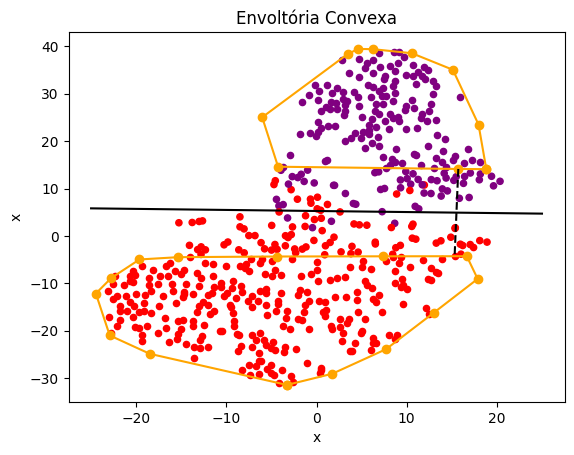

In [63]:
# reta classificadora
b, m = reta_perpendicular(p1,p2)

# Gerando valores x para a reta perpendicular
x_valores = np.linspace(-25, 25, 100)

# Gerando valores y para a reta perpendicular
y_valores = reta(m, b ,x_valores)

# Mapeamento de cores (0: azul, 1: vermelho)
cores = np.array(['purple' if v == 0 else 'red' for v in teste[:,2]])

# Criação do gráfico
plt.plot(x_valores, y_valores, color='black')
plt.scatter(Xs0, Ys0, c='purple', label='Rótulo 0', s=20)
plt.scatter(Xs2, Ys2, c='red', label= 'Rótulo 1', s=20)
plt.plot(Xs1, Ys1, linestyle='-', marker='o', color='orange')
plt.plot(Xs3, Ys3, linestyle='-', marker='o', color='orange')
# Plotando os pontos com cores diferentes
plt.scatter(teste[:, 0], teste[:, 1], c=cores, s=20)


# Adiciona uma linha entre o par de pontos mais próximo
plt.plot([p1.x,p2.x], [p1.y,p2.y], 'k--')
plt.xlabel('x')
plt.ylabel('x')
plt.title('Envoltória Convexa')
plt.show()


In [64]:
# Calcular métricas
precisao = precision_score(teste[:, 2], rotulos)
revocacao = recall_score(teste[:, 2], rotulos)
f1 = f1_score(teste[:, 2], rotulos)

# Imprimir os resultados
print(f'Precisão: {precisao}')
print(f'Revocação: {revocacao}')
print(f'F1-escore: {f1}')


Precisão: 0.9487179487179487
Revocação: 0.8505747126436781
F1-escore: 0.896969696969697


## __5. Date Fruit Dataset__

Este conjunto de dados aborda a classificação de sete tipos de tâmaras: Barhee, Deglet Nour, Sukkary, Rotab Mozafati, Ruthana, Safawi e Sagai. Para atingir esse objetivo, foram coletadas 898 imagens desses tipos de tâmaras usando um sistema de visão computacional. Utilizando técnicas de processamento de imagem, foram extraídas 34 características, incluindo características morfológicas, forma e cor, dessas imagens.

Os resultados das métricas de avaliação para este dataset foram os seguintes:

**a) Precisão: 0.86**

**b) Revocação: 0.96**

**c) F1-escore: 0.91**

In [65]:
# carregandop arquivo
arquivo_excel = 'https://raw.githubusercontent.com/milenamoreira/geometria-computacional/main/data/Date_Fruit_Datasets.csv'

# pegando dados do Excel
data = pd.read_csv(arquivo_excel)

df = pd.DataFrame(data)


In [66]:
# reduzindo dataset para duas classes
df = df[(df['Class'] == 'BERHI') | (df['Class'] == 'SOGAY')]

In [67]:
# Função para mapear os valores da coluna 'class' para 0 ou 1
def rotulo_binario(valor):
    return 0 if valor == 'BERHI' else 1

# atribuindo rotulos binarios para a classe
df['Class'] = df['Class'].apply(lambda x: rotulo_binario(x))


In [68]:
# Separar as features (x) e a variável de rotulo(y)
df = df.apply(lambda x: x.astype(str).str.replace(',', '.').astype(float))

Y = df['Class']
X = df.drop(columns=['Class'])

# Padronizar e aplicar o PCA diretamente no DataFrame
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Adiciona coluna rótulo à matriz de pontos
X_pca = np.column_stack((X_pca, Y.to_numpy()))


In [69]:
# selecionando bases de teste e treino
treino = X_pca[(X_pca[:, 0] < -1.5) | (X_pca[:, 0] > 3)]
teste = X_pca[~(X_pca[:, 0] < -1.5) & ~(X_pca[:, 0] > 3)]

#separando as amostras
treino_amostra0 = treino[treino[:, 2] == 0]
treino_amostra1 = treino[treino[:, 2] == 1]


In [70]:
# guardando amostras distintas em listas separadas, e gerando a envoltória de cada uma
amostra0 = [Ponto(x, y, r) for x, y, r in treino_amostra0]
envoltoria_amostra_0 = gift_wrapping(amostra0)

amostra1 = [Ponto(x, y, r) for x, y, r in treino_amostra1]
envoltoria_amostra_1 = gift_wrapping(amostra1)

In [71]:
# Criando listas separadas para pontos e envoltoria
Xs0 = [ponto.x for ponto in amostra0]
Ys0 = [ponto.y for ponto in amostra0]

Xs1 = [ponto.x for ponto in envoltoria_amostra_0]
Ys1 = [ponto.y for ponto in envoltoria_amostra_0]
Xs1.append(envoltoria_amostra_0[0].x)
Ys1.append(envoltoria_amostra_0[0].y)

# Criando listas separadas para pontos e envoltoria
Xs2 = [ponto.x for ponto in amostra1]
Ys2 = [ponto.y for ponto in amostra1]

Xs3 = [ponto.x for ponto in envoltoria_amostra_1]
Ys3 = [ponto.y for ponto in envoltoria_amostra_1]
Xs3.append(envoltoria_amostra_1[0].x)
Ys3.append(envoltoria_amostra_1[0].y)



In [72]:
# verificando intercessao de segmentos
any_segment_intersect(envoltoria_amostra_0, envoltoria_amostra_1)

Os dados são linearmente separáveis.


False

In [73]:
# juntando amostras
todas_amostras = amostra0 + amostra1

# par mais proximo
p1, p2 = par_mais_proximo(todas_amostras)

# classificando pontos de teste de acordo com modelo
teste_pontos = [Ponto(x, y, r) for x, y, r in teste]
rotulos = classificar_pontos(p1, p2, teste_pontos, 0, 1)

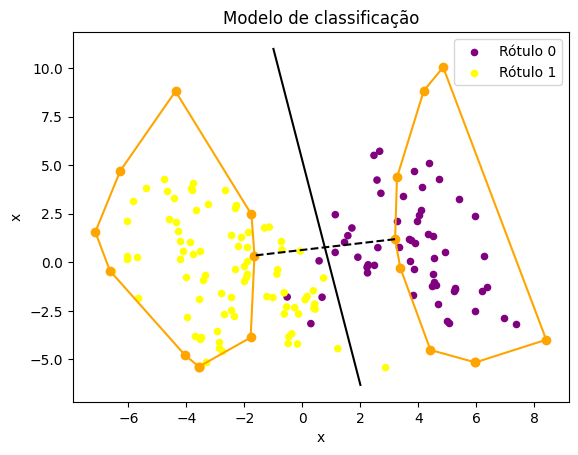

In [74]:

# reta classificadora
b, m = reta_perpendicular(p1,p2)

# Gerando valores x para a reta perpendicular
x_valores = np.linspace(-1, 2, 10)

# Gerando valores y para a reta perpendicular
y_valores = reta(m, b ,x_valores)

# Mapeamento de cores (0: azul, 1: vermelho)
cores = np.array(['purple' if v == 0 else 'yellow' for v in teste[:,2]])

# Criação do gráfico
plt.plot(x_valores, y_valores, color='black')
plt.scatter(Xs0, Ys0, c='purple', label='Rótulo 0', s=20)
plt.scatter(Xs2, Ys2, c='yellow', label= 'Rótulo 1', s=20)
plt.plot(Xs1, Ys1, linestyle='-', marker='o', color='orange')
plt.plot(Xs3, Ys3, linestyle='-', marker='o', color='orange')
# Plotando os pontos com cores diferentes
plt.scatter(teste[:, 0], teste[:, 1], c=cores, s=20)


# Adiciona uma linha entre o par de pontos mais próximo
plt.plot([p1.x,p2.x], [p1.y,p2.y], 'k--')
plt.legend()
plt.xlabel('x')
plt.ylabel('x')
plt.title('Modelo de classificação')
plt.show()

In [75]:

# Calcular métricas
precisao = precision_score(teste[:, 2], rotulos)
revocacao = recall_score(teste[:, 2], rotulos)
f1 = f1_score(teste[:, 2], rotulos)

# Imprimir os resultados
print(f'Precisão: {precisao}')
print(f'Revocação: {revocacao}')
print(f'F1-escore: {f1}')


Precisão: 0.8666666666666667
Revocação: 0.9629629629629629
F1-escore: 0.912280701754386


## __6.Citrus Dataset__

Este conjunto de dados utiliza a cor, peso e diâmetro para classificar laranjas e toranjas. Essas fatures podem ser interpretadas pelo modelo para classificação binária entre os dois tipos de fruta.
(https://www.kaggle.com/datasets/joshmcadams/oranges-vs-grapefruit)

Resultados das métricas para o Citrus dataset:

**a) Precisão: 0.59**

**b) Revocação: 0.84**

**c) F1-escore: 0.69**

In [76]:
# carregandop arquivo
arquivo_csv = 'https://raw.githubusercontent.com/milenamoreira/geometria-computacional/main/data/citrus.csv'

# pegando dados do Excel
data = pd.read_csv(arquivo_csv)

df = pd.DataFrame(data)


In [77]:
df= df.sample( frac=1, random_state=42)  # frac=1 significa embaralhar todas as linhas
df = df[:1000] # reducao da tabela

In [78]:
# Função para mapear os valores da coluna rotulo para 0 ou 1
def rotulo_binario(valor):
    return 0 if valor == 'orange' else 1

# Aplicar a função à coluna 'localidade' e criar uma nova coluna chamada 'rotulo'
df['name'] = df['name'].apply(lambda x: rotulo_binario(x))

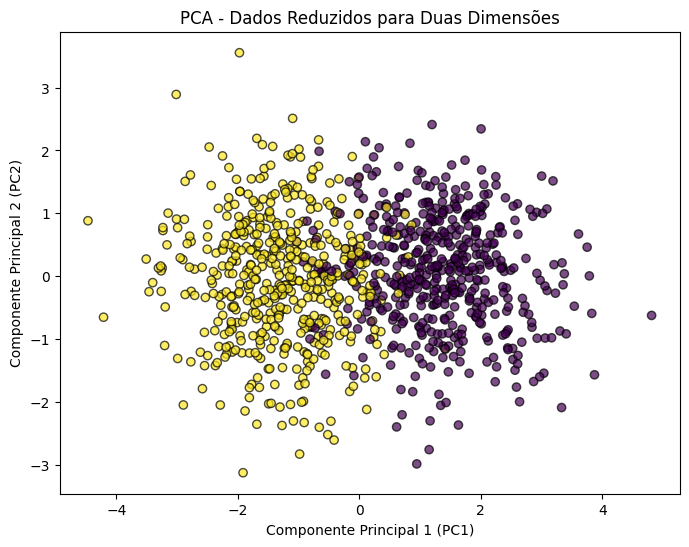

In [79]:
# Separar as features (X) e a variável de rotulo
Y = df['name']
X = df.drop(columns=['name'])

# Padronizar e aplicar o PCA diretamente no DataFrame
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Adicionar rótulo à matriz de pontos
X_pca = np.column_stack((X_pca, Y))

# Visualizar os dados reduzidos para duas dimensões
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X_pca[:, 2], cmap='viridis', edgecolor='k', alpha=0.7)
plt.title('PCA - Dados Reduzidos para Duas Dimensões')
plt.xlabel('Componente Principal 1 (PC1)')
plt.ylabel('Componente Principal 2 (PC2)')
plt.show()

<ipython-input-80-a2d1a924137b>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(treino[:, 0], treino[:, 1], c='blue', label='Treino', cmap='viridis', edgecolor='k', alpha=0.7)
<ipython-input-80-a2d1a924137b>:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(teste[:, 0], teste[:, 1], c='yellow', label='Teste', cmap='viridis', edgecolor='k', alpha=0.7)


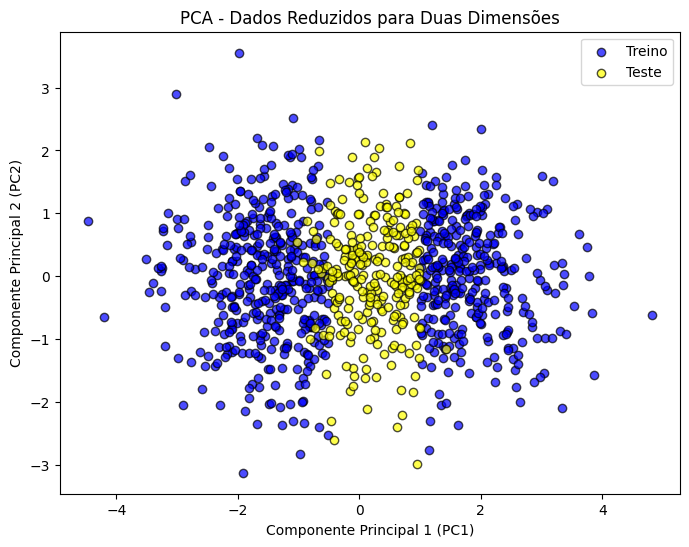

In [80]:
# selecionando dados para treino e teste
treino = X_pca[((X_pca[:,0] < -0.5) & (X_pca[:, 2] == 1)) | ((X_pca[:, 0] > 1) & (X_pca[:, 2] == 0))]
teste = X_pca[~((X_pca[:,0] < -0.5) & (X_pca[:, 2] == 1)) & ~((X_pca[:, 0] > 1) & (X_pca[:, 2] == 0))]

# Visualizar os dados reduzidos para duas dimensões
plt.figure(figsize=(8, 6))
plt.scatter(treino[:, 0], treino[:, 1], c='blue', label='Treino', cmap='viridis', edgecolor='k', alpha=0.7)
plt.scatter(teste[:, 0], teste[:, 1], c='yellow', label='Teste', cmap='viridis', edgecolor='k', alpha=0.7)
plt.title('PCA - Dados Reduzidos para Duas Dimensões')
# Adicionando legenda
plt.legend()
plt.xlabel('Componente Principal 1 (PC1)')
plt.ylabel('Componente Principal 2 (PC2)')
plt.show()

Aproximadamente $35\%$ dos dados serão usados pra teste, e $75\%$ para treino.

In [81]:
#separando as amostras
treino_amostra0 = treino[treino[:, 2] == 0]
treino_amostra1 = treino[treino[:, 2] == 1]

In [82]:
# guardando amostras distintas em listas separadas, e gerando a envoltória de cada uma
amostra0 = [Ponto(x, y, r) for x, y, r in treino_amostra0]
envoltoria_amostra_0 = gift_wrapping(amostra0)

amostra1 = [Ponto(x, y, r) for x, y, r in treino_amostra1]
envoltoria_amostra_1 = gift_wrapping(amostra1)

In [83]:
Xs0 = [ponto.x for ponto in amostra0]
Ys0 = [ponto.y for ponto in amostra0]

Xs1 = [ponto.x for ponto in envoltoria_amostra_0]
Ys1 = [ponto.y for ponto in envoltoria_amostra_0]
Xs1.append(envoltoria_amostra_0[0].x)
Ys1.append(envoltoria_amostra_0[0].y)

# Criando listas separadas para pontos e envoltoria
Xs2 = [ponto.x for ponto in amostra1]
Ys2 = [ponto.y for ponto in amostra1]

Xs3 = [ponto.x for ponto in envoltoria_amostra_1]
Ys3 = [ponto.y for ponto in envoltoria_amostra_1]
Xs3.append(envoltoria_amostra_1[0].x)
Ys3.append(envoltoria_amostra_1[0].y)

In [84]:
# verificando intercessao de segmentos
any_segment_intersect(envoltoria_amostra_0, envoltoria_amostra_1)

Os dados são linearmente separáveis.


False

In [85]:
# juntando amostras
todas_amostras = amostra0 + amostra1

# par mais proximo
p1, p2 = par_mais_proximo(todas_amostras)

# classificando pontos de teste de acordo com modelo
teste_pontos = [Ponto(x, y, r) for x, y, r in teste]
rotulos = classificar_pontos(p1, p2, teste_pontos, 0, 1)

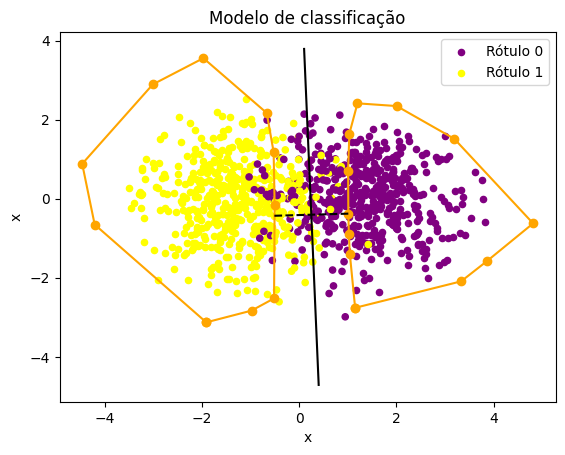

In [86]:
# reta classificadora
b, m = reta_perpendicular(p1,p2)

# Gerando valores x para a reta perpendicular
x_valores = np.linspace(0.1, 0.4, 10)

# Gerando valores y para a reta perpendicular
y_valores = reta(m, b ,x_valores)

# Mapeamento de cores (0: roxo, 1: amarelo)
cores = np.array(['purple' if v == 0 else 'yellow' for v in teste[:,2]])

# Criação do gráfico
plt.plot(x_valores, y_valores, color='black')
plt.scatter(Xs0, Ys0, c='purple', label='Rótulo 0', s=20)
plt.scatter(Xs2, Ys2, c='yellow', label= 'Rótulo 1', s=20)
plt.plot(Xs1, Ys1, linestyle='-', marker='o', color='orange')
plt.plot(Xs3, Ys3, linestyle='-', marker='o', color='orange')
# Plotando os pontos com cores diferentes
plt.scatter(teste[:, 0], teste[:, 1], c=cores, s=20)


# Adiciona uma linha entre o par de pontos mais próximo
plt.plot([p1.x,p2.x], [p1.y,p2.y], 'k--')
plt.legend()
plt.xlabel('x')
plt.ylabel('x')
plt.title('Modelo de classificação')
plt.show()

In [87]:

# Calcular métricas
precisao = precision_score(teste[:, 2], rotulos)
revocacao = recall_score(teste[:, 2], rotulos)
f1 = f1_score(teste[:, 2], rotulos)

# Imprimir os resultados
print(f'Precisão: {precisao}')
print(f'Revocação: {revocacao}')
print(f'F1-escore: {f1}')


Precisão: 0.5970149253731343
Revocação: 0.8421052631578947
F1-escore: 0.6986899563318777


## __7. Pistacchio Dataset__

O Pistacchio possui 2148 observações distribuídas em duas classes.

Resultados das métricas para este dataset:

**a) Precisão: 0.55**

**b) Revocação: 0.83**

**c) F1-escore: 0.66**

In [88]:
# Carregar arquivo
arquivo_csv = 'https://raw.githubusercontent.com/milenamoreira/geometria-computacional/main/data/Pistachio_16_Features_Dataset%20-%20Pistachio_Dataset.csv'
seeds = pd.read_csv(arquivo_csv)
df = pd.DataFrame(seeds)
df['Class'] = df['Class'].replace({'Kirmizi_Pistachio': 0, 'Siit_Pistachio': 1})
df = df.rename(columns={'Class': 'Target'})

In [89]:
# Substituir virgulas por pontos e converter para float
df = df.apply(lambda x: x.astype(str).str.replace(',', '.').astype(float))
df_copia = df
svd = TruncatedSVD(n_components=2, n_iter=5, random_state=42)
dados_transformados = svd.fit_transform(df_copia)
df_bidimensional = pd.DataFrame(dados_transformados, columns=['x','y'])
df_bidimensional['Target'] = df_copia['Target'].astype(int)
df = df_bidimensional

Plotando as envoltorias das duas classes, podemos observar que os dados não são linearmente separáveis. Portanto, a aplicação do método (1) foi necessária, como demonstrado a seguir

<Figure size 640x480 with 0 Axes>

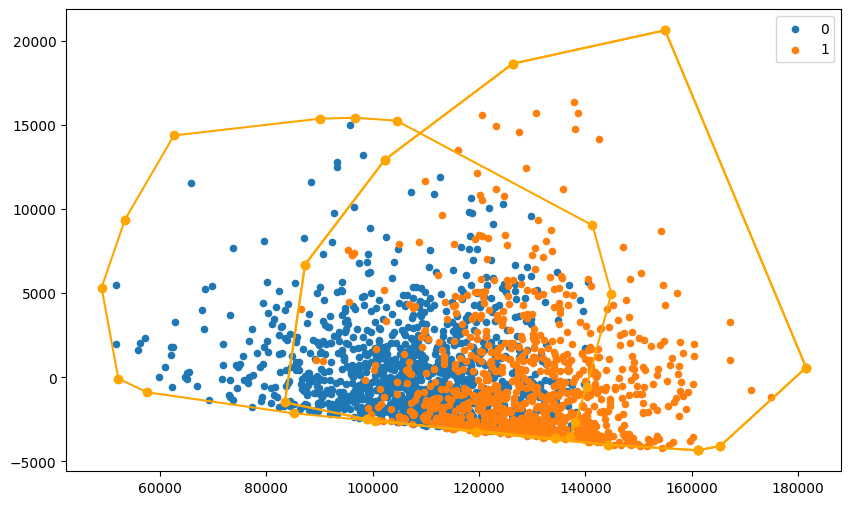

In [90]:
envoltorias = []
plt.clf()
plt.figure(figsize = (10, 6))
names = [0, 1]
for i in range(len(names)):
  classe = df[df['Target'] == i]
  classe = classe.values
  classe_points = [Ponto(x, y, r) for x, y, r in classe]
  envoltorias.append(gift_wrapping(classe_points))
  Xs1 = [ponto.x for ponto in classe_points]
  Ys1 = [ponto.y for ponto in classe_points]
  plt.scatter(Xs1, Ys1, s=20, label=names[i])
  Xs2 = [ponto.x for ponto in envoltorias[i]]
  Ys2 = [ponto.y for ponto in envoltorias[i]]
  Xs2.append(envoltorias[i][0].x)
  Ys2.append(envoltorias[i][0].y)
  for p in envoltorias:
    plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')
plt.legend()
plt.show()

<ipython-input-91-bf72425aaf00>:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(treino.x, treino.y, c='blue', label='Treino', cmap='viridis', edgecolor='k', alpha=0.7)
<ipython-input-91-bf72425aaf00>:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(teste.x, teste.y, c='yellow', label='Teste', cmap='viridis', edgecolor='k', alpha=0.7)


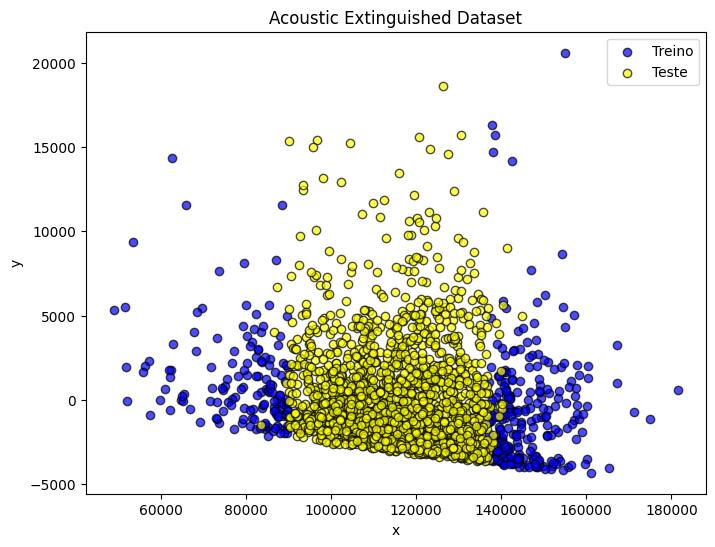

In [91]:
treino = df[(df['x'] <= 90000) & (df['Target'] == 0) | (df['x'] > 137000) & (df['Target'] == 1)]
teste = df[(df['x'] > 90000) & (df['Target'] == 0) | (df['x'] <= 137000) & (df['Target'] == 1)]

teste_labels = teste.Target
treino_labels = treino.Target

# # Visualizar os dados reduzidos para duas dimensões
plt.figure(figsize=(8, 6))
plt.scatter(treino.x, treino.y, c='blue', label='Treino', cmap='viridis', edgecolor='k', alpha=0.7)
plt.scatter(teste.x, teste.y, c='yellow', label='Teste', cmap='viridis', edgecolor='k', alpha=0.7)
plt.title('Acoustic Extinguished Dataset')
# Adicionando legenda
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Ao separar em teste e treinamento, analisando novamente as suas envoltórias, podemos observar que os dados escolhidos, agora, não se cruzam.

In [92]:
pontos_A, pontos_B = gerar_pontos(treino,0,1)
envoltoria_A, envoltoria_B = gerar_envoltorias(pontos_A, pontos_B)

In [93]:
any_segment_intersect(envoltoria_A, envoltoria_B)

Os dados são linearmente separáveis.


False

In [94]:
pontos_treino = [Ponto(x, y, r) for x, y, r in treino.values]
pontos_teste = [Ponto(x, y, r) for x, y, r in teste.values]

uniao = pontos_A + pontos_B
p1, p2 = par_mais_proximo(uniao)
rotulos_teste = classificar_pontos(p1, p2, pontos_teste, 0, 1)

Pontos de treinamento, reta e conjunto de pontos mais próximos (das envoltórias)

<Figure size 640x480 with 0 Axes>

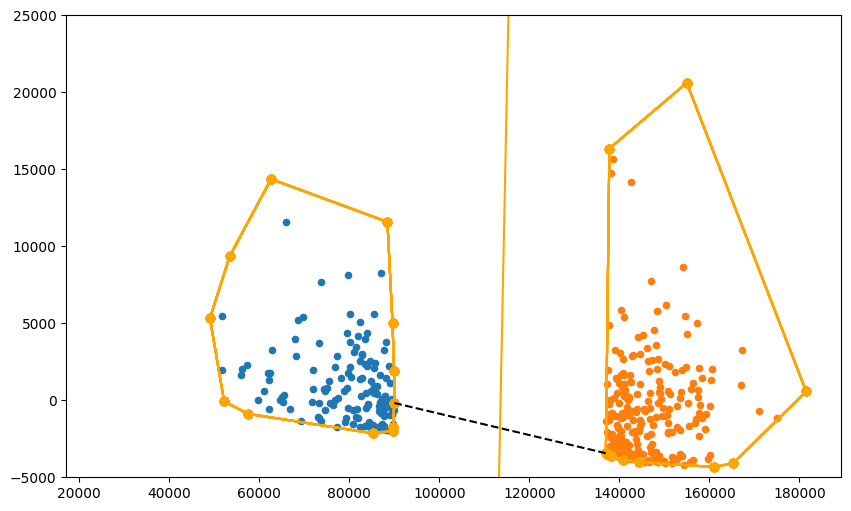

In [95]:
P1 = Ponto(p1.x, p1.y, p1.rotulo)
P2 = Ponto(p2.x, p2.y, p2.rotulo)
b, m = reta_perpendicular(P1,P2)

x_valores = np.linspace(25000, 180000, 5)
y_valores = reta(m, b ,x_valores)
plt.clf()
plt.figure(figsize = (10, 6))

Xs1 = [ponto.x for ponto in pontos_A]
Ys1 = [ponto.y for ponto in pontos_A]
plt.scatter(Xs1, Ys1, s=20)
Xs2 = [ponto.x for ponto in envoltoria_A]
Ys2 = [ponto.y for ponto in envoltoria_A]
Xs2.append(envoltoria_A[0].x)
Ys2.append(envoltoria_A[0].y)
for p in envoltoria_A:
    plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')

Xs1 = [ponto.x for ponto in pontos_B]
Ys1 = [ponto.y for ponto in pontos_B]
plt.scatter(Xs1, Ys1, s=20)
Xs2 = [ponto.x for ponto in envoltoria_B]
Ys2 = [ponto.y for ponto in envoltoria_B]
Xs2.append(envoltoria_B[0].x)
Ys2.append(envoltoria_B[0].y)
for p in envoltoria_B:
      plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')

# plotando a reta classificadora
plt.plot(x_valores, y_valores, color='orange')

# Adiciona uma linha entre o par de pontos mais próximo
plt.plot([p1.x,p2.x], [p1.y,p2.y], 'k--')
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(-5000, 25000)

plt.show()

In [96]:
# Calcular métricas
recall = recall_score(teste_labels, rotulos_teste)
precision = precision_score(teste_labels, rotulos_teste)
f1 = f1_score(teste_labels, rotulos_teste)

print(f'Precisão: {precision}')
print(f'Revocação: {recall}')
print(f'F1-escore: {f1}')

Precisão: 0.5568065506653019
Revocação: 0.8318042813455657
F1-escore: 0.6670754138565297


## __8. Penguin Dataset__

O Penguin dataset é semelhante ao Iris na quantidade de observações e classes: aqui temos 344 pontos distribuídos em 3 rótulos. No entanto, nenhuma das classes é linearmente separável.

Porém, após executar o método PCA sobre os dados, as classes "Adelie" e "Gentoo" tornaram-se linearmente separáveis, o que facilitou o experimento.

Assim, foi necessário apenas separar os dados em conjuntos de treino e teste aleatoriamente, seguindo a proporção 70:30. Depois disso, simplesmente seguimos o passo a passo para obter o desempenho das métricas.

No caso do Penguin, os resultado do cálculo das métricas foram:

**a)Precisão: 1.0**

**b)Revocação: 0.97**

**c)F1-escore: 0.98**


In [97]:
# Carregar arquivo csv
arquivo_csv = "https://raw.githubusercontent.com/milenamoreira/geometria-computacional/main/data/penguins.csv"
df = pd.read_csv(arquivo_csv)

# Remover valores NaN
df.dropna(inplace = True)

# Remover variáveis categóricas
df = df.drop(columns=['island', 'sex', 'year'])

# Mapear rotulos para numeros inteiros
df['species'] = df['species'].replace({'Adelie': 0, 'Gentoo': 1, 'Chinstrap': 2})

# Manter apenas dois rotulos
df = df.loc[df['species'].isin([0, 1])]

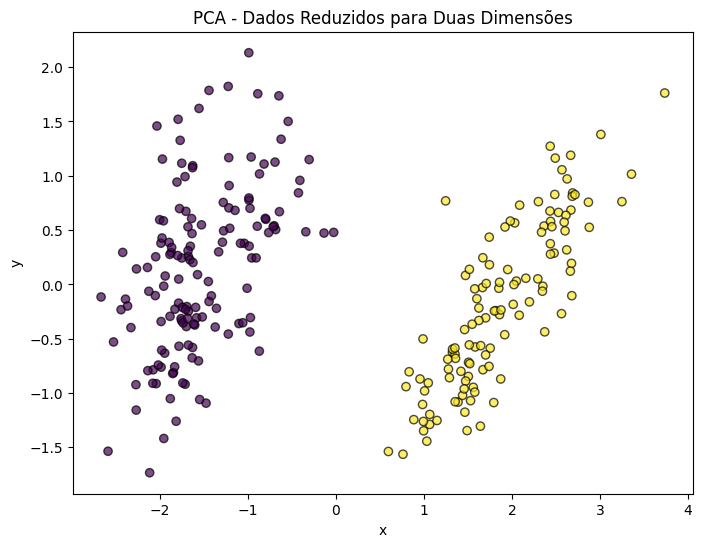

In [98]:
# Separar as features e o rotulo
rotulo = df['species']
features = df.drop(columns=['species'])

# Padronizar e aplicar o PCA diretamente no DataFrame
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Adicionar rótulo à matriz de pontos
features_pca = np.column_stack((features_pca, rotulo))

# Visualizar os dados reduzidos para duas dimensões
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=features_pca[:, 2], cmap='viridis', edgecolor='k', alpha=0.7)
plt.title('PCA - Dados Reduzidos para Duas Dimensões')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [99]:
# Transformar os dados bidimensionais em dataframe
df = pd.DataFrame(features_pca, columns=['x','y', 'Target'])

# Separar o dataset em treino e teste
df_treino, df_teste, targets_treino, targets_teste = separar_dados(df)

In [100]:
# Gerar os pontos para o conjunto de treino
pontos_A, pontos_B = gerar_pontos(df_treino, 0, 1)

# Gerar as envoltórias para o conjunto de treino
envoltoria_A, envoltoria_B = gerar_envoltorias(pontos_A, pontos_B)

In [101]:
# Verificar se os segmentos se interceptam
any_segment_intersect(envoltoria_A, envoltoria_B)

Os dados são linearmente separáveis.


False

In [102]:
# União dos conjuntos de pontos
uniao = pontos_A + pontos_B

# Pares de pontos mais próximos
p1, p2 = par_mais_proximo(uniao)

# Classificar pontos de teste de acordo com modelo
pontos_teste = [Ponto(x, y, r) for x, y, r in df_teste.values]
rotulos = classificar_pontos(p1, p2, pontos_teste, 1, 0)

In [103]:
b, m = b, m = reta_perpendicular(p1,p2)

# Gerando valores x para a reta perpendicular
x_valores = np.linspace(-1, 4, 6)

# Gerando valores y para a reta perpendicular
y_valores = reta(m, b ,x_valores)

In [104]:
pontos_teste = [Ponto(x, y, r) for x, y, r in df_teste.values]
pontos_teste_A, pontos_teste_B = gerar_pontos(df_teste, 0, 1)

<Figure size 640x480 with 0 Axes>

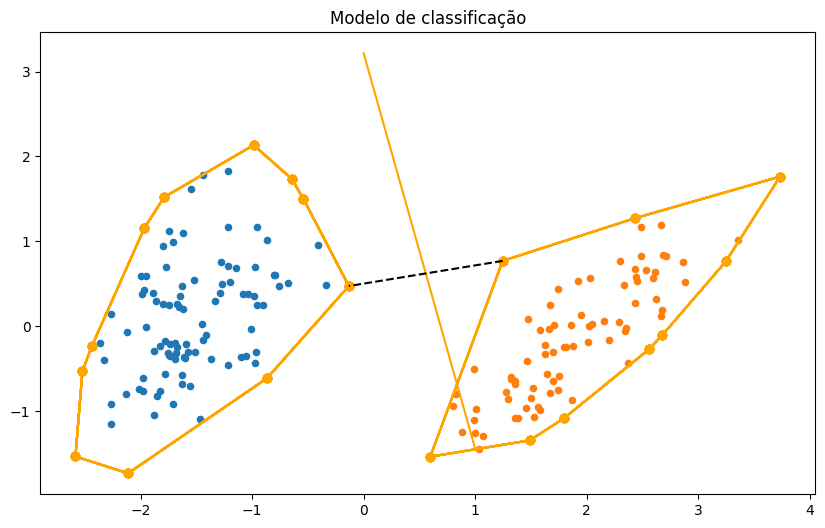

In [105]:
# gerar reta classificadora
P1 = Ponto(p1.x, p1.y, p1.rotulo)
P2 = Ponto(p2.x, p2.y, p2.rotulo)
b, m = reta_perpendicular(P1,P2)
gerar_grafico_reta(b, m, 0, 1, pontos_A, pontos_B, envoltoria_A, envoltoria_B, P1, P2)

In [106]:
pontos_teste = [Ponto(x, y, r) for x, y, r in df_teste.values]
rotulos_teste = classificar_pontos(p1, p2, pontos_teste, 1, 0)

In [107]:
# Calcular métricas
recall = recall_score(targets_teste, rotulos_teste)
precision = precision_score(targets_teste, rotulos_teste)
f1 = f1_score(targets_teste, rotulos_teste)

print(f'Precisão: {precision}')
print(f'Revocação: {recall}')
print(f'F1-escore: {f1}')

Precisão: 1.0
Revocação: 0.9714285714285714
F1-escore: 0.9855072463768115


##__9. Pumpkin Seeds Dataset__


O Pumpkin Seeds dataset possui 2500 observações divididas em duas classes não separáveis linearmente.
O dataset também tem 12 variáveis. Para reduzir as dimensões deste dataset usamos a técnica t-SNE, que permitiu separar o dataset em conjuntos de treino e teste de tal modo que mantemos a proporção 70:30. Neste caso, selecionamos os intervalos de intersecção entre as classes e transformamos no conjunto de teste. Assim, o conjunto de treino se tornou linearmente separável e foi possível performar todas as tarefas necessárias para gerar o modelo de classificação.

O desempenho das métricas foi o seguinte:

**a) Precisão: 0.75**

**b) Revocação: 0.98**

**c) F1-escore: 0.85**

In [108]:
# carregar dataset
arquivo_csv = "https://raw.githubusercontent.com/milenamoreira/geometria-computacional/main/data/Pumpkin_Seeds_Dataset.csv"
seeds = pd.read_csv(arquivo_csv)
df = pd.DataFrame(seeds)
# mapear rotulos para números inteiros
df['Class'] = df['Class'].replace({'Çerçevelik': 0, 'Ürgüp Sivrisi': 1})

In [109]:
# Separar as features e o rotulo
rotulo = df['Class']
features = df.drop(columns=['Class'])

# Padronizar os dados
X_padronizado = StandardScaler().fit_transform(features)

# Usar k-NN para encontrar os vizinhos
n_vizinhos = 5
vizinhos = NearestNeighbors(n_neighbors=n_vizinhos)
ajuste_vizinhos = vizinhos.fit(X_padronizado)
distancias, indices = ajuste_vizinhos.kneighbors(X_padronizado)

# Usar t-SNE para redução de dimensionalidade
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_padronizado)

# Adicionar rótulo à matriz de pontos
X_tsne_com_rotulo = np.column_stack((X_tsne, rotulo))

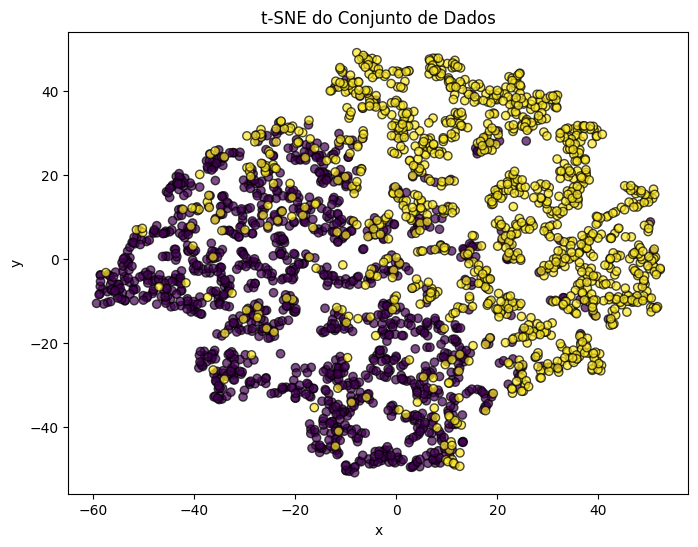

In [110]:
# Plotar os dados reduzidos
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=X_tsne_com_rotulo[:, 2], cmap='viridis', edgecolor='k', alpha=0.7)
plt.title('t-SNE do Conjunto de Dados')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [111]:
# Transformar os dados bidimensionais em dataframe
df = pd.DataFrame(X_tsne_com_rotulo, columns=['x','y', 'Target'])

In [112]:
# Selecionar dados para treino e teste
df_teste = df[((df['Target'] == 0) & (df['x'] > -5)) | ((df['Target'] == 1) & (df['x'] < 5))]
df_treino = df[((df['Target'] == 0) & (df['x'] <= -5)) | ((df['Target'] == 1) & (df['x'] >= 5))]


<ipython-input-113-c5a45d506a47>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(treino[:, 0], treino[:, 1], c='red', label='Treino', cmap='viridis', edgecolor='k', alpha=0.7)
<ipython-input-113-c5a45d506a47>:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(teste[:, 0], teste[:, 1], c='grey', label='Teste', cmap='viridis', edgecolor='k', alpha=0.7)


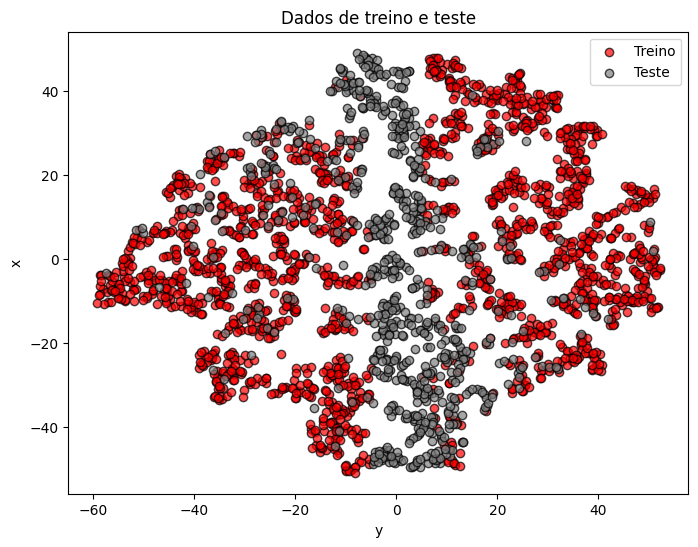

In [113]:
# Plotar gráfico dos conjuntos de treino e teste
teste = df_teste.to_numpy()
treino = df_treino.to_numpy()

# Visualizar os dados reduzidos para duas dimensões
plt.figure(figsize=(8, 6))
plt.scatter(treino[:, 0], treino[:, 1], c='red', label='Treino', cmap='viridis', edgecolor='k', alpha=0.7)
plt.scatter(teste[:, 0], teste[:, 1], c='grey', label='Teste', cmap='viridis', edgecolor='k', alpha=0.7)
plt.title('Dados de treino e teste')
# Adicionando legenda
plt.legend()
plt.xlabel('y')
plt.ylabel('x')
plt.show()

In [114]:
# Gerar os pontos para o conjunto de treino
pontos_A, pontos_B = gerar_pontos(df_treino, 0, 1)

# Gerar as envoltórias para o conjunto de treino
envoltoria_A, envoltoria_B = gerar_envoltorias(pontos_A, pontos_B)

In [115]:
# Verificar se os segmentos se interceptam
any_segment_intersect(envoltoria_A, envoltoria_B)

Os dados são linearmente separáveis.


False

In [116]:
# União dos conjuntos de pontos
uniao = pontos_A + pontos_B

# Pares de pontos mais próximos
p1, p2 = par_mais_proximo(uniao)

# Classificar pontos de teste de acordo com modelo
pontos_teste = [Ponto(x, y, r) for x, y, r in df_teste.values]
rotulos_preditos = classificar_pontos(p1, p2, pontos_teste, 1, 0)

<Figure size 640x480 with 0 Axes>

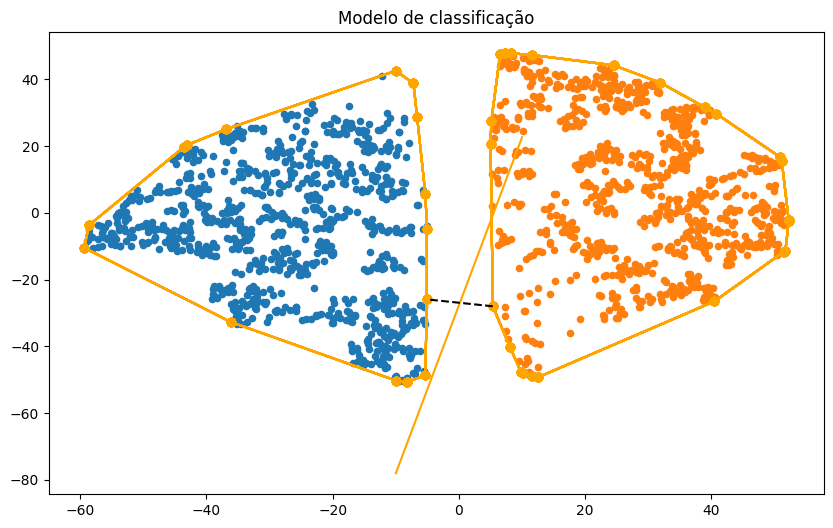

In [117]:
# Gerar reta classificadora
P1 = Ponto(p1.x, p1.y, p1.rotulo)
P2 = Ponto(p2.x, p2.y, p2.rotulo)
b, m = reta_perpendicular(P1,P2)
gerar_grafico_reta(b, m, -10, 10, pontos_A, pontos_B, envoltoria_A, envoltoria_B, P1, P2)

In [118]:
# Calcular métricas
recall = recall_score(teste[:, 2], rotulos_preditos)
precision = precision_score(teste[:, 2], rotulos_preditos)
f1 = f1_score(teste[:, 2], rotulos_preditos)

print(f'Precisão: {precision}')
print(f'Revocação: {recall}')
print(f'F1-escore: {f1}')

Precisão: 0.7471264367816092
Revocação: 0.9818731117824774
F1-escore: 0.8485639686684072


## **10. Banknote Dataset**

O Banknote Dataset envolve a previsão de se uma determinada cédula bancária é autêntica, dado um conjunto de medidas obtidas a partir de uma fotografia.

É um problema de classificação binária. O número de observações para cada classe não é equilibrado. Existem 1.372 observações com 4 variáveis de entrada e 1 variável de saída.

Os resultados das métricas foram o seguinte:

**a)Precisão: 0.57**

**b)Revocação: 0.98**

**c)F1-escore: 0.72**

O primeiro passo para a análise do dataset é a sua visualização. O dataset contava com quatro variáveis de entrada, mas queremos mudar sua dimensionalidade, e, para isso, usaremos o SVD.

In [119]:
arquivo_data = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
banknote = pd.read_table(arquivo_data, header=None, sep=',')
df = pd.DataFrame(banknote)
minha_lista = [str(numero) for numero in range(0, 4)]
df.columns = [f"{item}" for item in minha_lista] + ['Target']

In [120]:
# Transformação do df em apenas duas variaveis
df_copia = df
svd = TruncatedSVD(n_components=2, n_iter=5, random_state=42)
df.drop(columns=['Target'])
dados_transformados = svd.fit_transform(df)
df_bidimensional = pd.DataFrame(dados_transformados, columns=['x','y'])
df_bidimensional['Target'] = df_copia['Target']
df = df_bidimensional

Já que os dados não eram linearmente separáveis, a ideia para a separação do dataset em teste e treinamento foi baseada no critério já mencionado anteriormente:



1.   Pontos que estão misturados, são usados para teste
2.   Pontos que estão visivelmente separados, são usados como treinamento.

<Figure size 640x480 with 0 Axes>

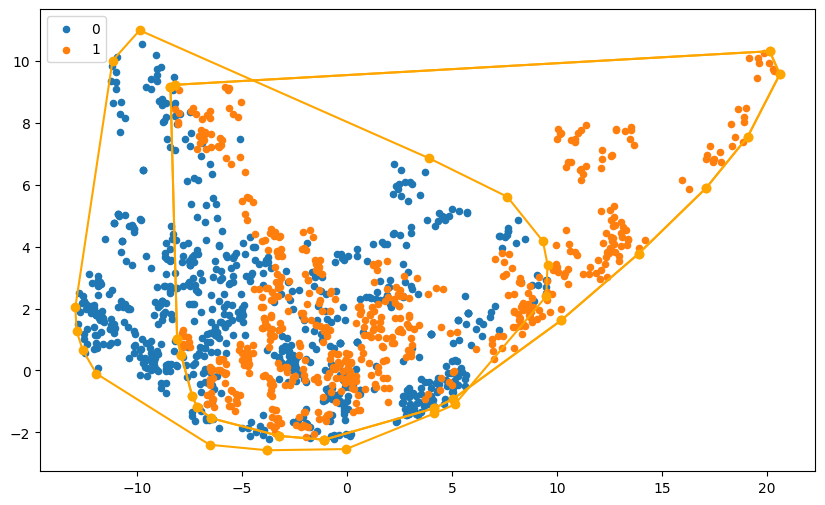

In [121]:
envoltorias = []
plt.clf()
plt.figure(figsize = (10, 6))
names = [0, 1]
for i in range(len(names)):
  bucket = df[df['Target'] == i]
  bucket = bucket.values
  bucket_points = [Ponto(x, y, r) for x, y, r in bucket]
  envoltorias.append(gift_wrapping(bucket_points))
  Xs1 = [ponto.x for ponto in bucket_points]
  Ys1 = [ponto.y for ponto in bucket_points]
  plt.scatter(Xs1, Ys1, s=20, label=names[i])
  Xs2 = [ponto.x for ponto in envoltorias[i]]
  Ys2 = [ponto.y for ponto in envoltorias[i]]
  Xs2.append(envoltorias[i][0].x)
  Ys2.append(envoltorias[i][0].y)
  for j in envoltorias:
    plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')
plt.legend()
plt.show()

<ipython-input-122-1218fd26c1a7>:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(treino.x, treino.y, c='blue', label='Treino', cmap='viridis', edgecolor='k', alpha=0.7)
<ipython-input-122-1218fd26c1a7>:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(teste.x, teste.y, c='yellow', label='Teste', cmap='viridis', edgecolor='k', alpha=0.7)


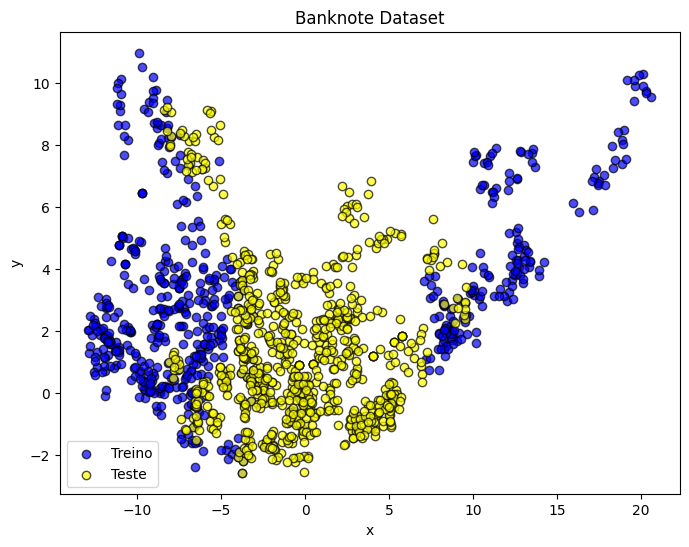

In [122]:
treino = df[(df['x'] <= -3) & (df['Target'] == 0) | (df['x'] > 7) & (df['Target'] == 1)]
teste = df[(df['x'] > -4) & (df['Target'] == 0) | (df['x'] <= 7) & (df['Target'] == 1)]

teste_labels = teste.Target
treino_labels = teste.Target

# # Visualizar os dados reduzidos para duas dimensões
plt.figure(figsize=(8, 6))
plt.scatter(treino.x, treino.y, c='blue', label='Treino', cmap='viridis', edgecolor='k', alpha=0.7)
plt.scatter(teste.x, teste.y, c='yellow', label='Teste', cmap='viridis', edgecolor='k', alpha=0.7)
plt.title('Banknote Dataset')
# Adicionando legenda
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()



Posteriormente, são geradas as envoltórias dos pontos de treinamento. Para fins de visualização, são geradas as envoltórias dos pontos em azul no gráfico anterior. Ao análisar se as mesmas se cruzam, podemos visualizar que não.

In [123]:
pontos_A_bk, pontos_B_bk = gerar_pontos(treino,0,1)
envoltoria_A_bk, envoltoria_B_bk = gerar_envoltorias(pontos_A_bk, pontos_B_bk)

In [124]:
any_segment_intersect(envoltoria_A_bk, envoltoria_B_bk)

Os dados são linearmente separáveis.


False

In [125]:
pontos_treino_bk = [Ponto(x, y, r) for x, y, r in treino.values]
pontos_teste_bk = [Ponto(x, y, r) for x, y, r in teste.values]

rotulos_teste_bk = classificar_pontos(p1, p2, pontos_teste_bk, 1,0)

Envoltórias dos pontos de treinamento, reta, e par de pontos mais próximos.

<Figure size 640x480 with 0 Axes>

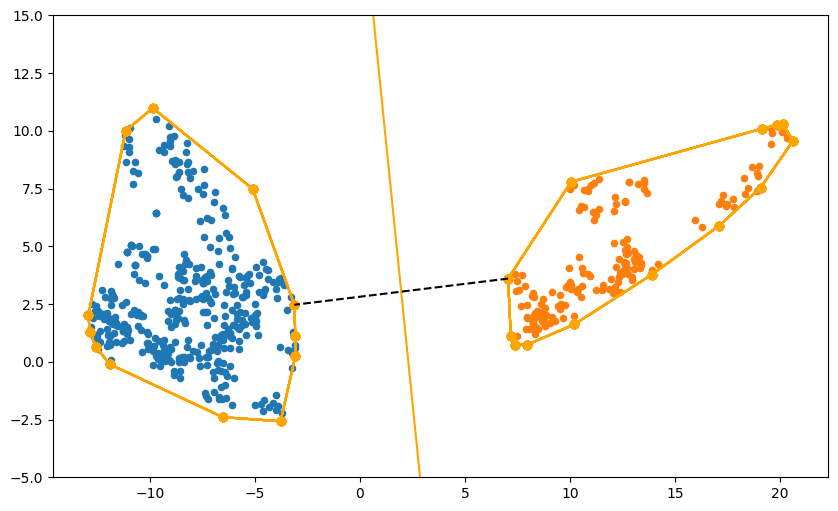

In [126]:
uniao_bk = pontos_A_bk + pontos_B_bk
p1, p2 = par_mais_proximo(uniao_bk)
P1 = Ponto(p1.x, p1.y, p1.rotulo)
P2 = Ponto(p2.x, p2.y, p2.rotulo)
b, m = reta_perpendicular(P1,P2)

x_valores = np.linspace(-2, 16, 5)
y_valores = reta(m, b ,x_valores)

plt.clf()
plt.figure(figsize = (10, 6))

Xs1 = [ponto.x for ponto in pontos_A_bk]
Ys1 = [ponto.y for ponto in pontos_A_bk]
plt.scatter(Xs1, Ys1, s=20)
Xs2 = [ponto.x for ponto in envoltoria_A_bk]
Ys2 = [ponto.y for ponto in envoltoria_A_bk]
Xs2.append(envoltoria_A_bk[0].x)
Ys2.append(envoltoria_A_bk[0].y)


for p in envoltoria_A_bk:
    plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')

Xs1 = [ponto.x for ponto in pontos_B_bk]
Ys1 = [ponto.y for ponto in pontos_B_bk]
plt.scatter(Xs1, Ys1, s=20)
Xs2 = [ponto.x for ponto in envoltoria_B_bk]
Ys2 = [ponto.y for ponto in envoltoria_B_bk]
Xs2.append(envoltoria_B_bk[0].x)
Ys2.append(envoltoria_B_bk[0].y)
for p in envoltoria_B_bk:
    plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')

# plotando a reta classificadora
plt.plot(x_valores, y_valores, color='orange')

# Adiciona uma linha entre o par de pontos mais próximo
plt.plot([p1.x,p2.x], [p1.y,p2.y], 'k--')
plt.ylim(-5, 15)

plt.show()

Analisando as métricas


1.  Cerca de 57% das previsões positivas feitas pelo modelo são realmente corretas. Esse valor se deve aos pontos estarem mais juntos desse dataset, apesar da divisão manual do treinamento e teste, existem pontos que não estão bem definidos quando se trata de sua classificação.
2.   No nosso caso, a revocação é aproximadamente 87%, o que significa que o modelo consegue identificar 92.6% de todos os casos positivos.
3. Nesse caso, obtemos um bom equilibrio entre as duas métricas


In [127]:
#esse é o caso contrario da função de classificar
recall = recall_score(teste_labels, rotulos_teste_bk)
precision = precision_score(teste_labels, rotulos_teste_bk)
f1 = f1_score(teste_labels, rotulos_teste_bk)

print(f'Precisão: {precision}')
print(f'Revocação: {recall}')
print(f'F1-escore: {f1}')

Precisão: 0.5702917771883289
Revocação: 0.9885057471264368
F1-escore: 0.7232968881412952


##__Extra - Ionosphere Dataset__


O dataset Ionosphere contém 2 classes e 17 variáveis. No entanto, a intersecção entre as envoltórias convexas geradas pelas duas classes contempla uma porcentagem significativa de todos os pontos. Sendo assim, o conjunto de treino para este dataset seria muito pequeno para gerar um modelo de classificação razoável.

In [128]:
# carregar dataset
arquivo_data = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
ionosphere = pd.read_table(arquivo_data, header=None, sep=',')
df = pd.DataFrame(ionosphere)
minha_lista = [str(numero) for numero in range(0, 34)]
#lista_formatada = [f"{item}" for item in minha_lista] + ['Target']
df.columns = [f"{item}" for item in minha_lista] + ['Target']
df['Target'] = df['Target'].replace({'g': 0, 'b': 1})


In [129]:
# fazer o SVD
df_copia = df
svd = TruncatedSVD(n_components=2, n_iter=5, random_state=42)
df.drop(columns=['Target'])
dados_transformados = svd.fit_transform(df)
df_bidimensional = pd.DataFrame(dados_transformados, columns=['x','y'])
df_bidimensional['Target'] = df_copia['Target']
df = df_bidimensional

<Figure size 640x480 with 0 Axes>

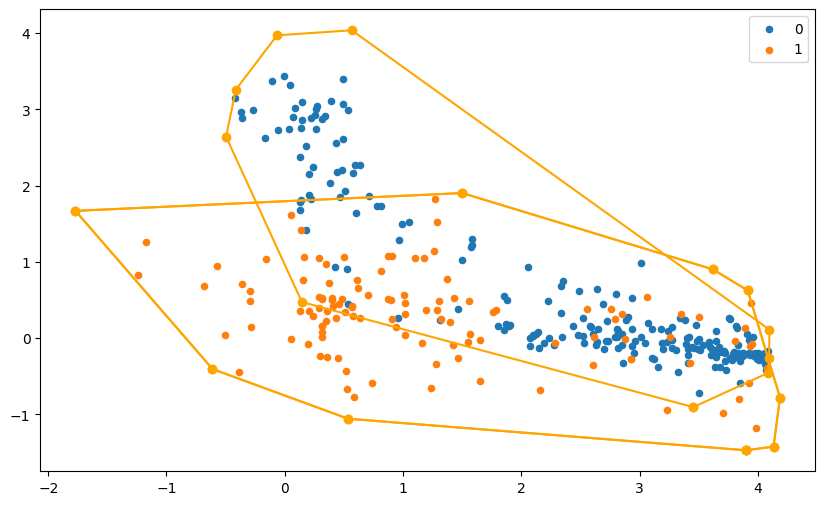

In [130]:
# gerar um grafico de todas as envoltorias convexas possiveis
envoltorias = []
plt.clf()
plt.figure(figsize = (10, 6))
names = [0, 1]
for i in range(len(names)):
  bucket = df[df['Target'] == i]
  bucket = bucket.values
  bucket_points = [Ponto(x, y, r) for x, y, r in bucket]
  envoltorias.append(gift_wrapping(bucket_points))
  Xs1 = [ponto.x for ponto in bucket_points]
  Ys1 = [ponto.y for ponto in bucket_points]
  plt.scatter(Xs1, Ys1, s=20, label=names[i])
  Xs2 = [ponto.x for ponto in envoltorias[i]]
  Ys2 = [ponto.y for ponto in envoltorias[i]]
  Xs2.append(envoltorias[i][0].x)
  Ys2.append(envoltorias[i][0].y)
  for j in envoltorias:
    plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')
plt.legend()
plt.show()

In [131]:
# Verificar se as envoltórias são linearmente separáveis.
any_segment_intersect(envoltorias[0], envoltorias[1])

Os dados NÃO são linearmente separáveis.


True